In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import dask
import dask.dataframe as dd
import time
import os
from IPython.display import display
import ast
import warnings
warnings.filterwarnings('ignore')
# import sweetviz as sv


# print(dask.__version__)

In [2]:
# Convert JSON to parquet files

# Paths to save the Parquet files
# parquet_dir = "../../data/processed/"

# # 1. 
# # Convert pandas DataFrames to Parquet
# data_tip = pd.read_json(f"../../data/raw/yelp_academic_dataset_tip.json", lines=True)
# data_tip.to_parquet(os.path.join(parquet_dir, "yelp_academic_dataset_tip.parquet"))

# # Convert Dask DataFrames to Parquet
# data_businesses = dd.read_json(f"../../data/raw/yelp_academic_dataset_business.json", lines=True)
# data_businesses.to_parquet(os.path.join(parquet_dir, "yelp_academic_dataset_business.parquet"))

# data_checkin = dd.read_json(f"../../data/raw/yelp_academic_dataset_checkin.json", lines=True)
# data_checkin.to_parquet(os.path.join(parquet_dir, "yelp_academic_dataset_checkin.parquet"))

# data_user = dd.read_json(f"../../data/raw/yelp_academic_dataset_user.json", lines=True)
# data_user.to_parquet(os.path.join(parquet_dir, "yelp_academic_dataset_user.parquet"))

# # Read the large JSON file with Dask in chunks and convert to Parquet
# data_review = dd.read_json(f"../../data/raw/yelp_academic_dataset_review.json", lines=True, blocksize="64MB")
# data_review.to_parquet(os.path.join(parquet_dir, "yelp_academic_dataset_review.parquet"))



# Read and save sample data for larger files
# data_user = dd.read_json('../../data/raw/yelp_academic_dataset_user.json', lines=True, blocksize=40000000)  # 1MB blocksize
# data_user_sample = data_user.head(5000)  # Adjust the number of rows to read
# data_user_sample.to_parquet(os.path.join(parquet_dir, "yelp_academic_dataset_review_user.parquet"))

# # Review Data
# data_review = dd.read_json(f"../../data/raw/yelp_academic_dataset_review.json", lines=True, blocksize=40000000)
# data_review = data_review.head(5000)
# data_review.to_parquet(os.path.join(parquet_dir, "yelp_academic_dataset_review_sample.parquet"))



In [3]:

# Load data and set indices
data_businesses = dd.read_parquet("../../data/processed/yelp_academic_dataset_business.parquet")
data_businesses = data_businesses.set_index('business_id')

data_checkin = dd.read_parquet("../../data/processed/yelp_academic_dataset_checkin.parquet")
data_checkin = data_checkin.set_index('business_id')

data_tip = dd.read_parquet("../../data/processed/yelp_academic_dataset_tip.parquet")

data_review_sample = dd.read_parquet("../../data/processed/yelp_academic_dataset_review_sample.parquet")
data_review_sample = data_review_sample.set_index('review_id')

data_user_sample = dd.read_parquet("../../data/processed/yelp_academic_dataset_user_sample.parquet")
data_user_sample = data_user_sample.set_index('user_id')


df_dict = {
    'bus_df': data_businesses,
    'checkin_df': data_checkin,
    'tip_df': data_tip,
    'review_df': data_review_sample,
    'user_df': data_user_sample
}


In [4]:

# Define the processing instructions
processes = {
    "bus_df": {
        "bool": ["is_open"],
        "dict": ["attributes", "hours"],
        "lists": ["categories"]
    },
    "checkin_df": {
        "date_time_list": ["date"]
    },
    "tip_df": {
        "date_time": ["date"],
        "string": ["text"]
    },
    "user_df": {
        "date_time": ["yelping_since"], #yelping since already shows in datetime...
        "lists": ["elite", "friends"]
    },
    "review_df": {
        "date_time": ["date"],
        "string": ["text"]
    }
}

for df_name, df in df_dict.items():
    
    instructions = processes[df_name]

    for dtype, cols in instructions.items():
        if dtype == "bool":
            for col in cols:
                df[col] = df[col].astype(bool)
        
        elif dtype == "date_time":
            for col in cols:
                df[col] = dd.to_datetime(df[col], errors='coerce')
                
        elif dtype == "string":
            for col in cols:
                df[col] = df[col].str.lower()
        
        elif dtype == "date_time_list":
            # continue
            for col in cols:
                df[col] = df[col].str.split(', ').map(
                    lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S", errors='coerce') 
                    if isinstance(x, list) else [],
                    meta=('x', 'object')
                )
        elif dtype == "dict":
            # continue
            for col in cols:
                df[col] = df[col].map(
                    lambda x: ast.literal_eval(x) if pd.notna(x) and isinstance(x, str) else {}, 
                    meta=('x', 'object')
                )
        
        elif dtype == "lists":
            # continue
            for col in cols:
                df[col] = df[col].map(
                    lambda x: x.split(', ') if pd.notna(x) and isinstance(x, str) else [], 
                    meta=('x', 'object')
                )
        
        

    # df_dict[df_name] = df

# If you need to compute the results, you can do so here:
# for df_name in df_dict:
#     df_dict[df_name] = df_dict[df_name].compute()

In [5]:
# Save dataset

# # Assuming df_dict contains Dask DataFrames
# for name, ddf in df_dict.items():
#     ddf.to_parquet(f'../../data/processed/{name}.parquet')  # or engine='fastparquet'


In [57]:
transformations = {
    "bus_df": {
        "log1p": ['review_count']
    },
    "review_df" : {
        "log1p" : ['stars', 'useful', 'funny', 'cool']
    },
    "user_df": {
        "log1p": ['review_count', 'useful', 'funny', 'cool', 'fans'] + [col for col in df_dict['user_df'].compute().columns if 'compliment' in col]   
    }
}

{'bus_df': {'log': ['review_count']}, 'review_df': {}}

In [6]:
# data_checkin.compute().describe() #taking too long...

for df_name, df in df_dict.items():
    if df_name != "checkin_df":
        print(df_name)
        display(df.compute().describe())
        

bus_df


,latitude,longitude,stars,review_count
count,150346.000000,150346.000000,150346.000000,150346.000000
mean,36.671150,-89.357339,3.596724,44.866561
std,5.872759,14.918502,0.974421,121.120136
min,27.555127,-120.095137,1.000000,5.000000
25%,32.187293,-90.357810,3.000000,8.000000
50%,38.777413,-86.121179,3.500000,15.000000
75%,39.954036,-75.421542,4.500000,37.000000
max,53.679197,-73.200457,5.000000,7568.000000


tip_df


,date,compliment_count
count,908915,908915.000000
mean,2015-06-14 10:13:53.302817280,0.012525
min,2009-04-16 13:11:49,0.000000
25%,2013-01-26 01:18:02.500000,0.000000
50%,2015-03-15 01:10:25,0.000000
75%,2017-08-02 06:19:55.500000,0.000000
max,2022-01-19 20:38:55,6.000000
std,NaN,0.120763


review_df


,stars,useful,funny,cool,date
count,5000.000000,5000.00000,5000.000000,5000.000000,5000
mean,3.838600,0.86880,0.252400,0.340000,2015-04-13 15:23:19.728400128
min,1.000000,0.00000,0.000000,0.000000,2005-03-12 03:47:06
25%,3.000000,0.00000,0.000000,0.000000,2013-10-25 00:11:22
50%,4.000000,0.00000,0.000000,0.000000,2015-09-23 23:04:05.500000
75%,5.000000,1.00000,0.000000,0.000000,2017-03-15 19:22:29
max,5.000000,34.00000,19.000000,13.000000,2018-10-04 18:10:01
std,1.357983,1.71947,0.904244,0.968601,NaN


user_df


,review_count,yelping_since,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,4211.000000,4211,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000
mean,341.816671,2009-05-08 13:15:50.810496512,1275.876276,684.314890,883.991926,44.503681,3.830869,93.666588,11.848730,9.772738,8.834244,5.336737,56.616481,144.450724,128.450962,128.450962,48.126098,37.050344
min,1.000000,2005-01-03 18:01:35,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,2008-03-15 06:30:46,60.000000,15.000000,19.000000,2.000000,3.600000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,145.000000,2009-06-18 21:29:13,244.000000,79.000000,101.000000,10.000000,3.830000,5.000000,2.000000,1.000000,0.000000,0.000000,7.000000,9.000000,10.000000,10.000000,4.000000,1.000000
75%,399.000000,2010-08-03 00:38:08.500000,868.000000,344.500000,436.500000,36.000000,4.060000,33.000000,7.000000,3.000000,3.000000,2.000000,28.000000,45.000000,51.000000,51.000000,22.500000,6.000000
max,9941.000000,2013-07-30 17:49:45,124311.000000,91842.000000,113069.000000,3138.000000,5.000000,12391.000000,3575.000000,5662.000000,1744.000000,2261.000000,4901.000000,16674.000000,13262.000000,13262.000000,6574.000000,14045.000000
std,582.808313,NaN,4488.603479,2908.094407,3755.493255,142.928365,0.431512,433.074690,69.657934,98.640596,51.187551,44.008681,218.024305,714.616047,562.896788,562.896788,223.647099,342.897864



Processing bus_df:


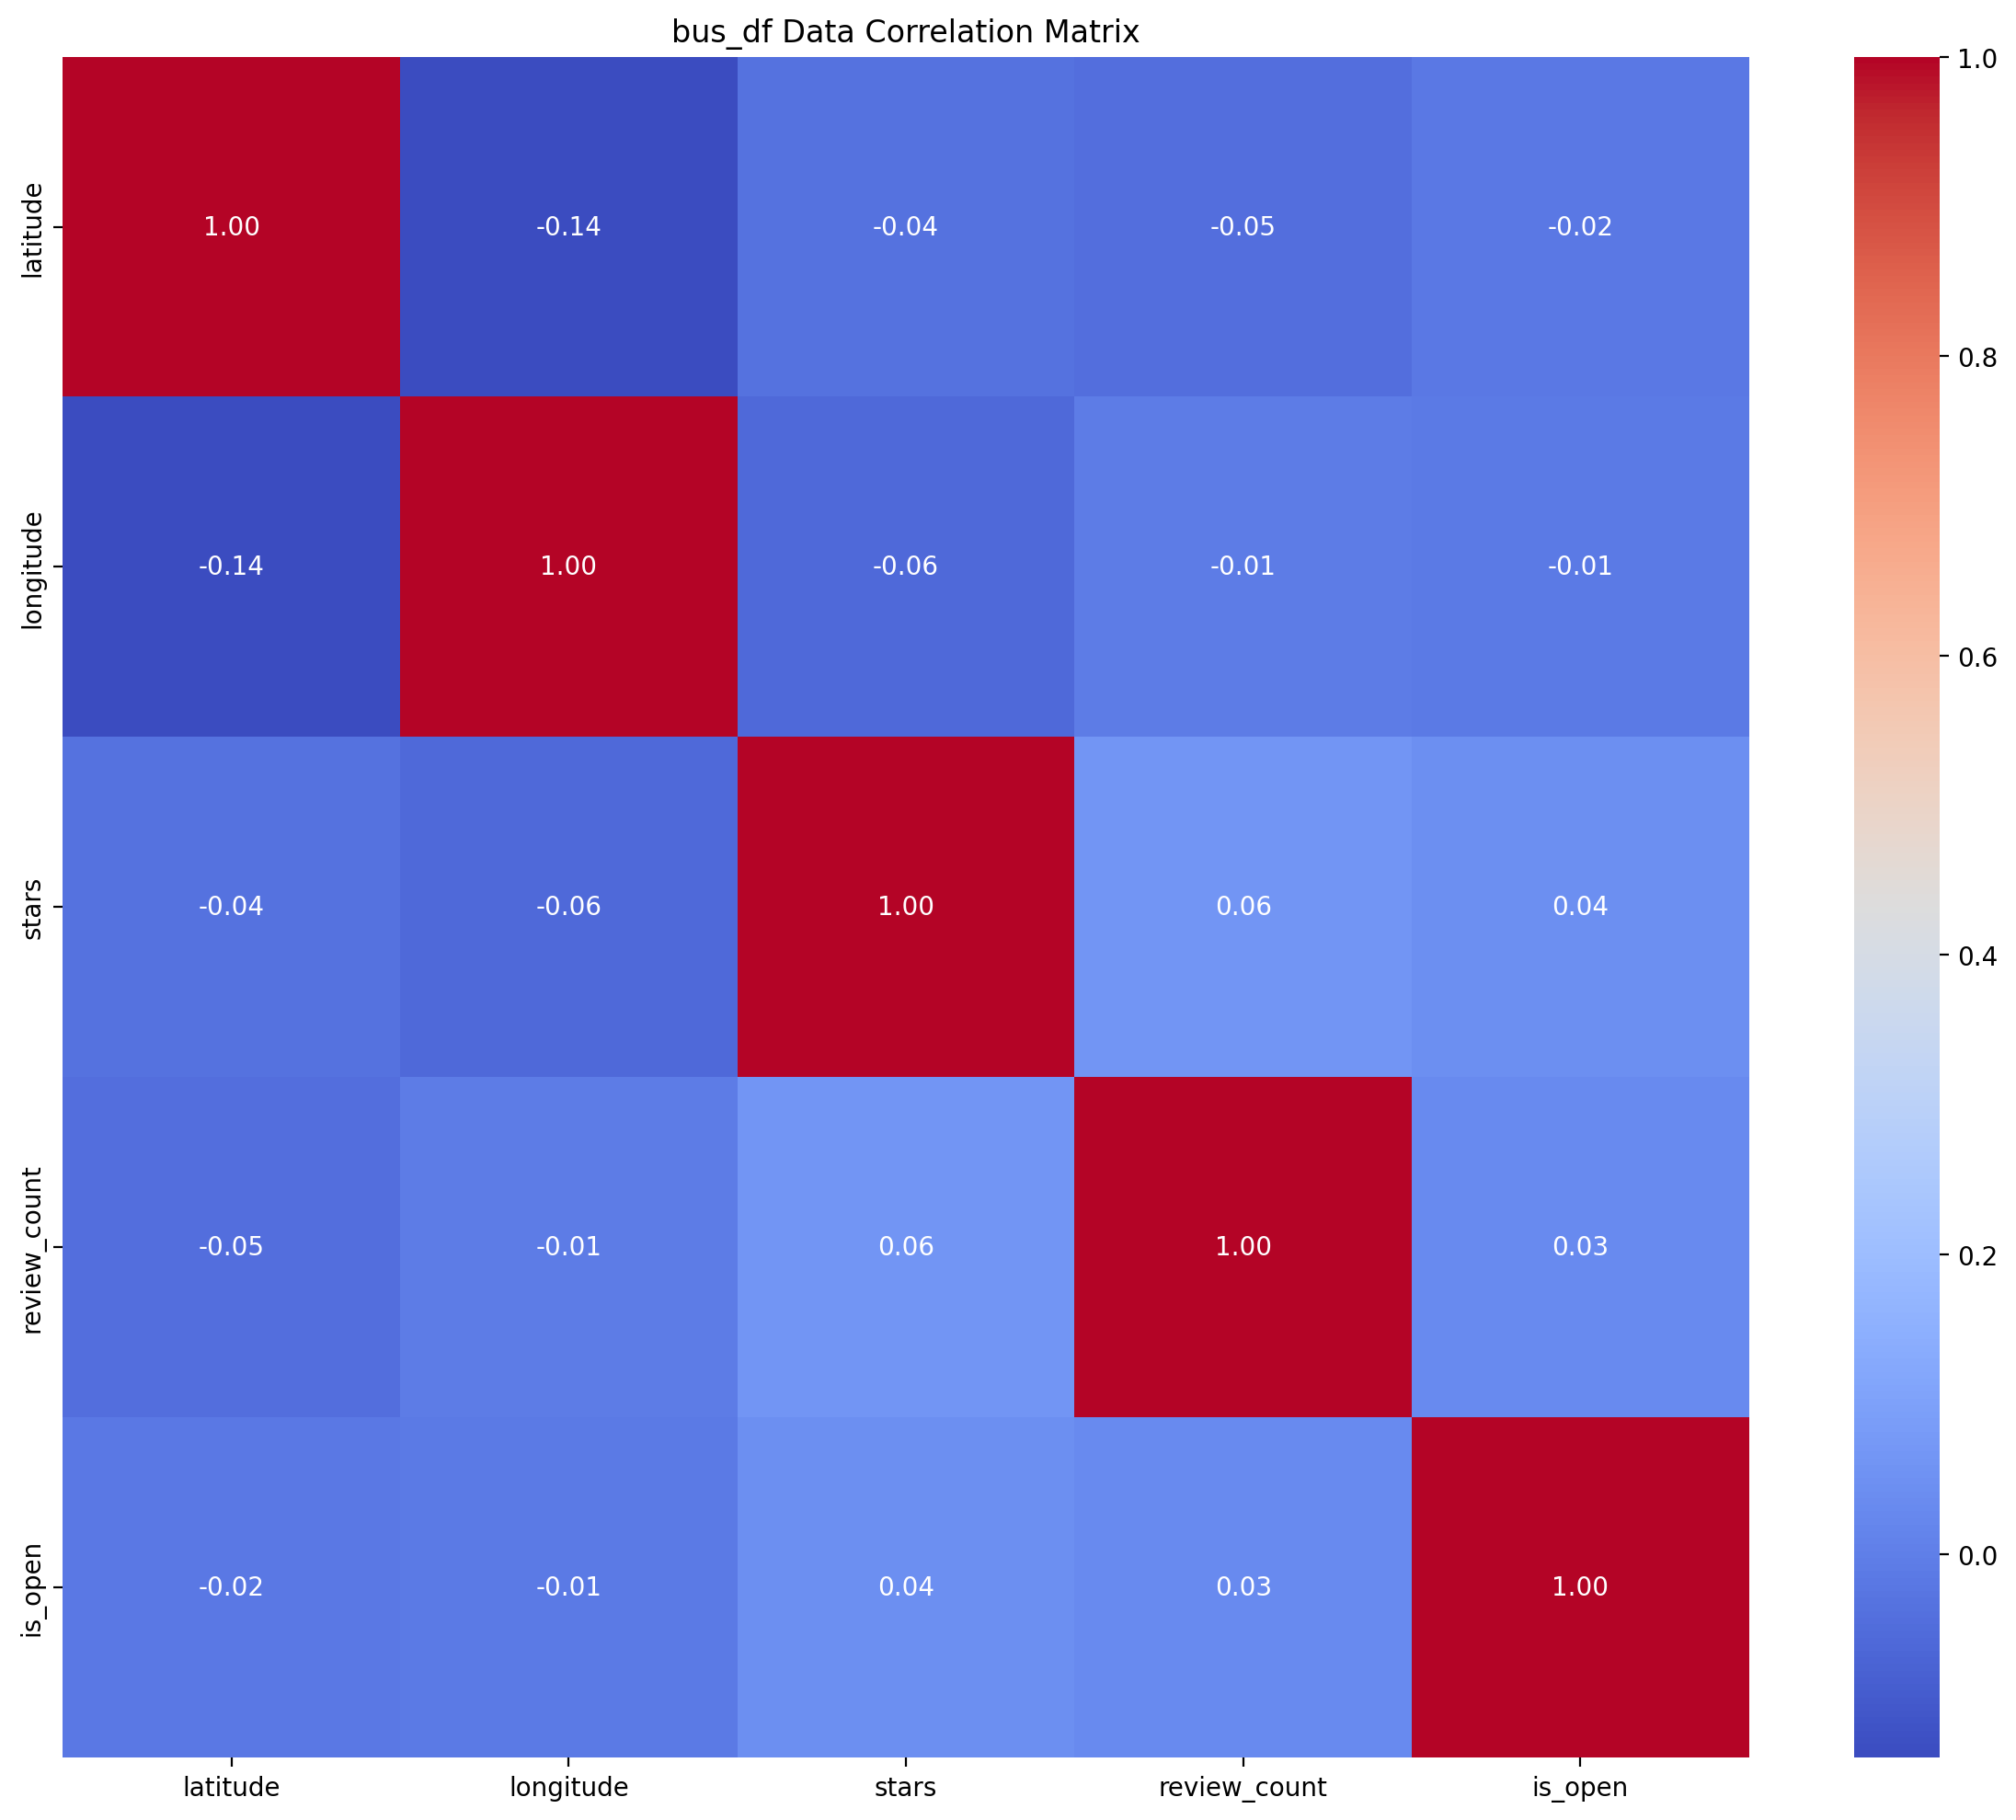

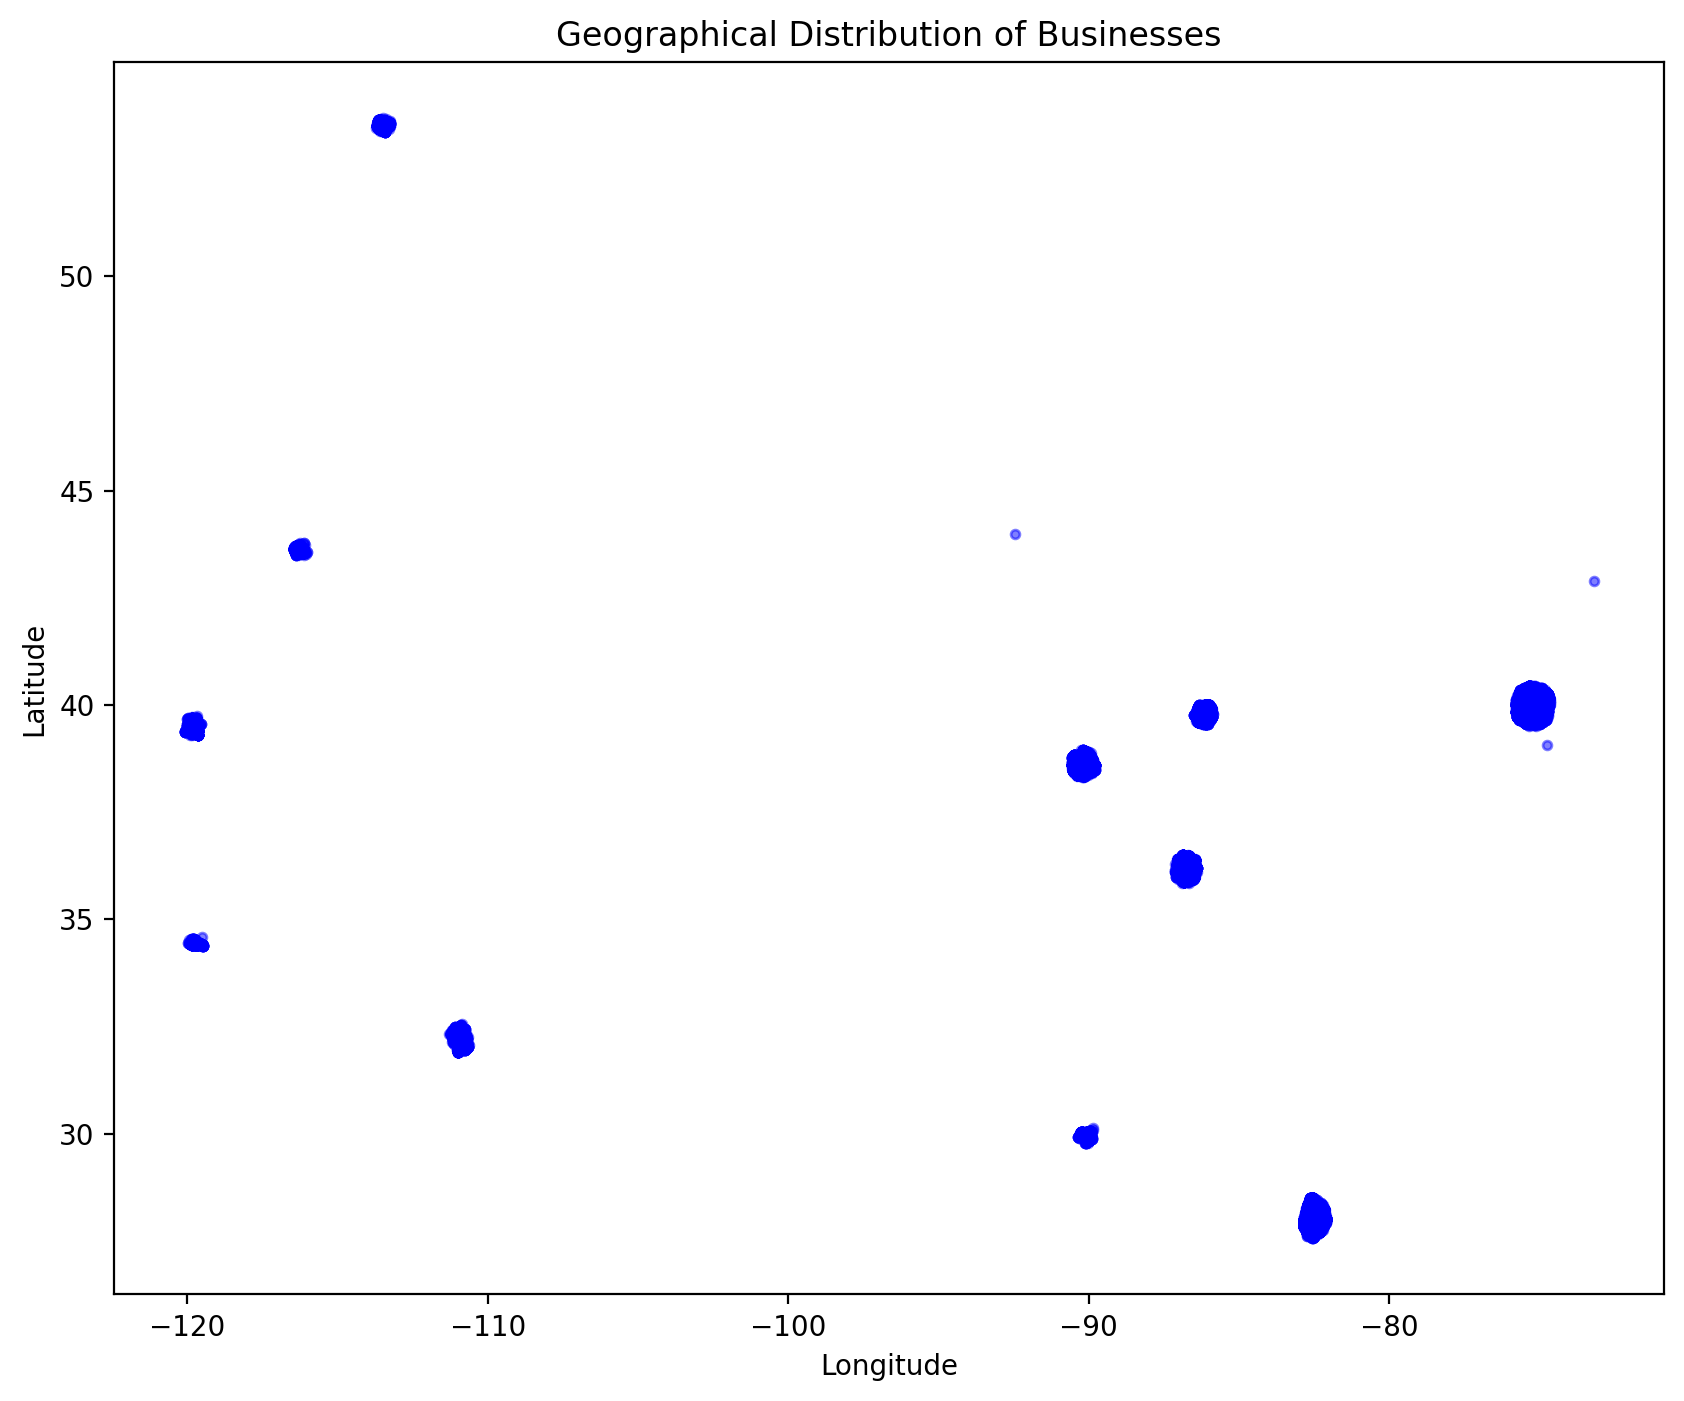

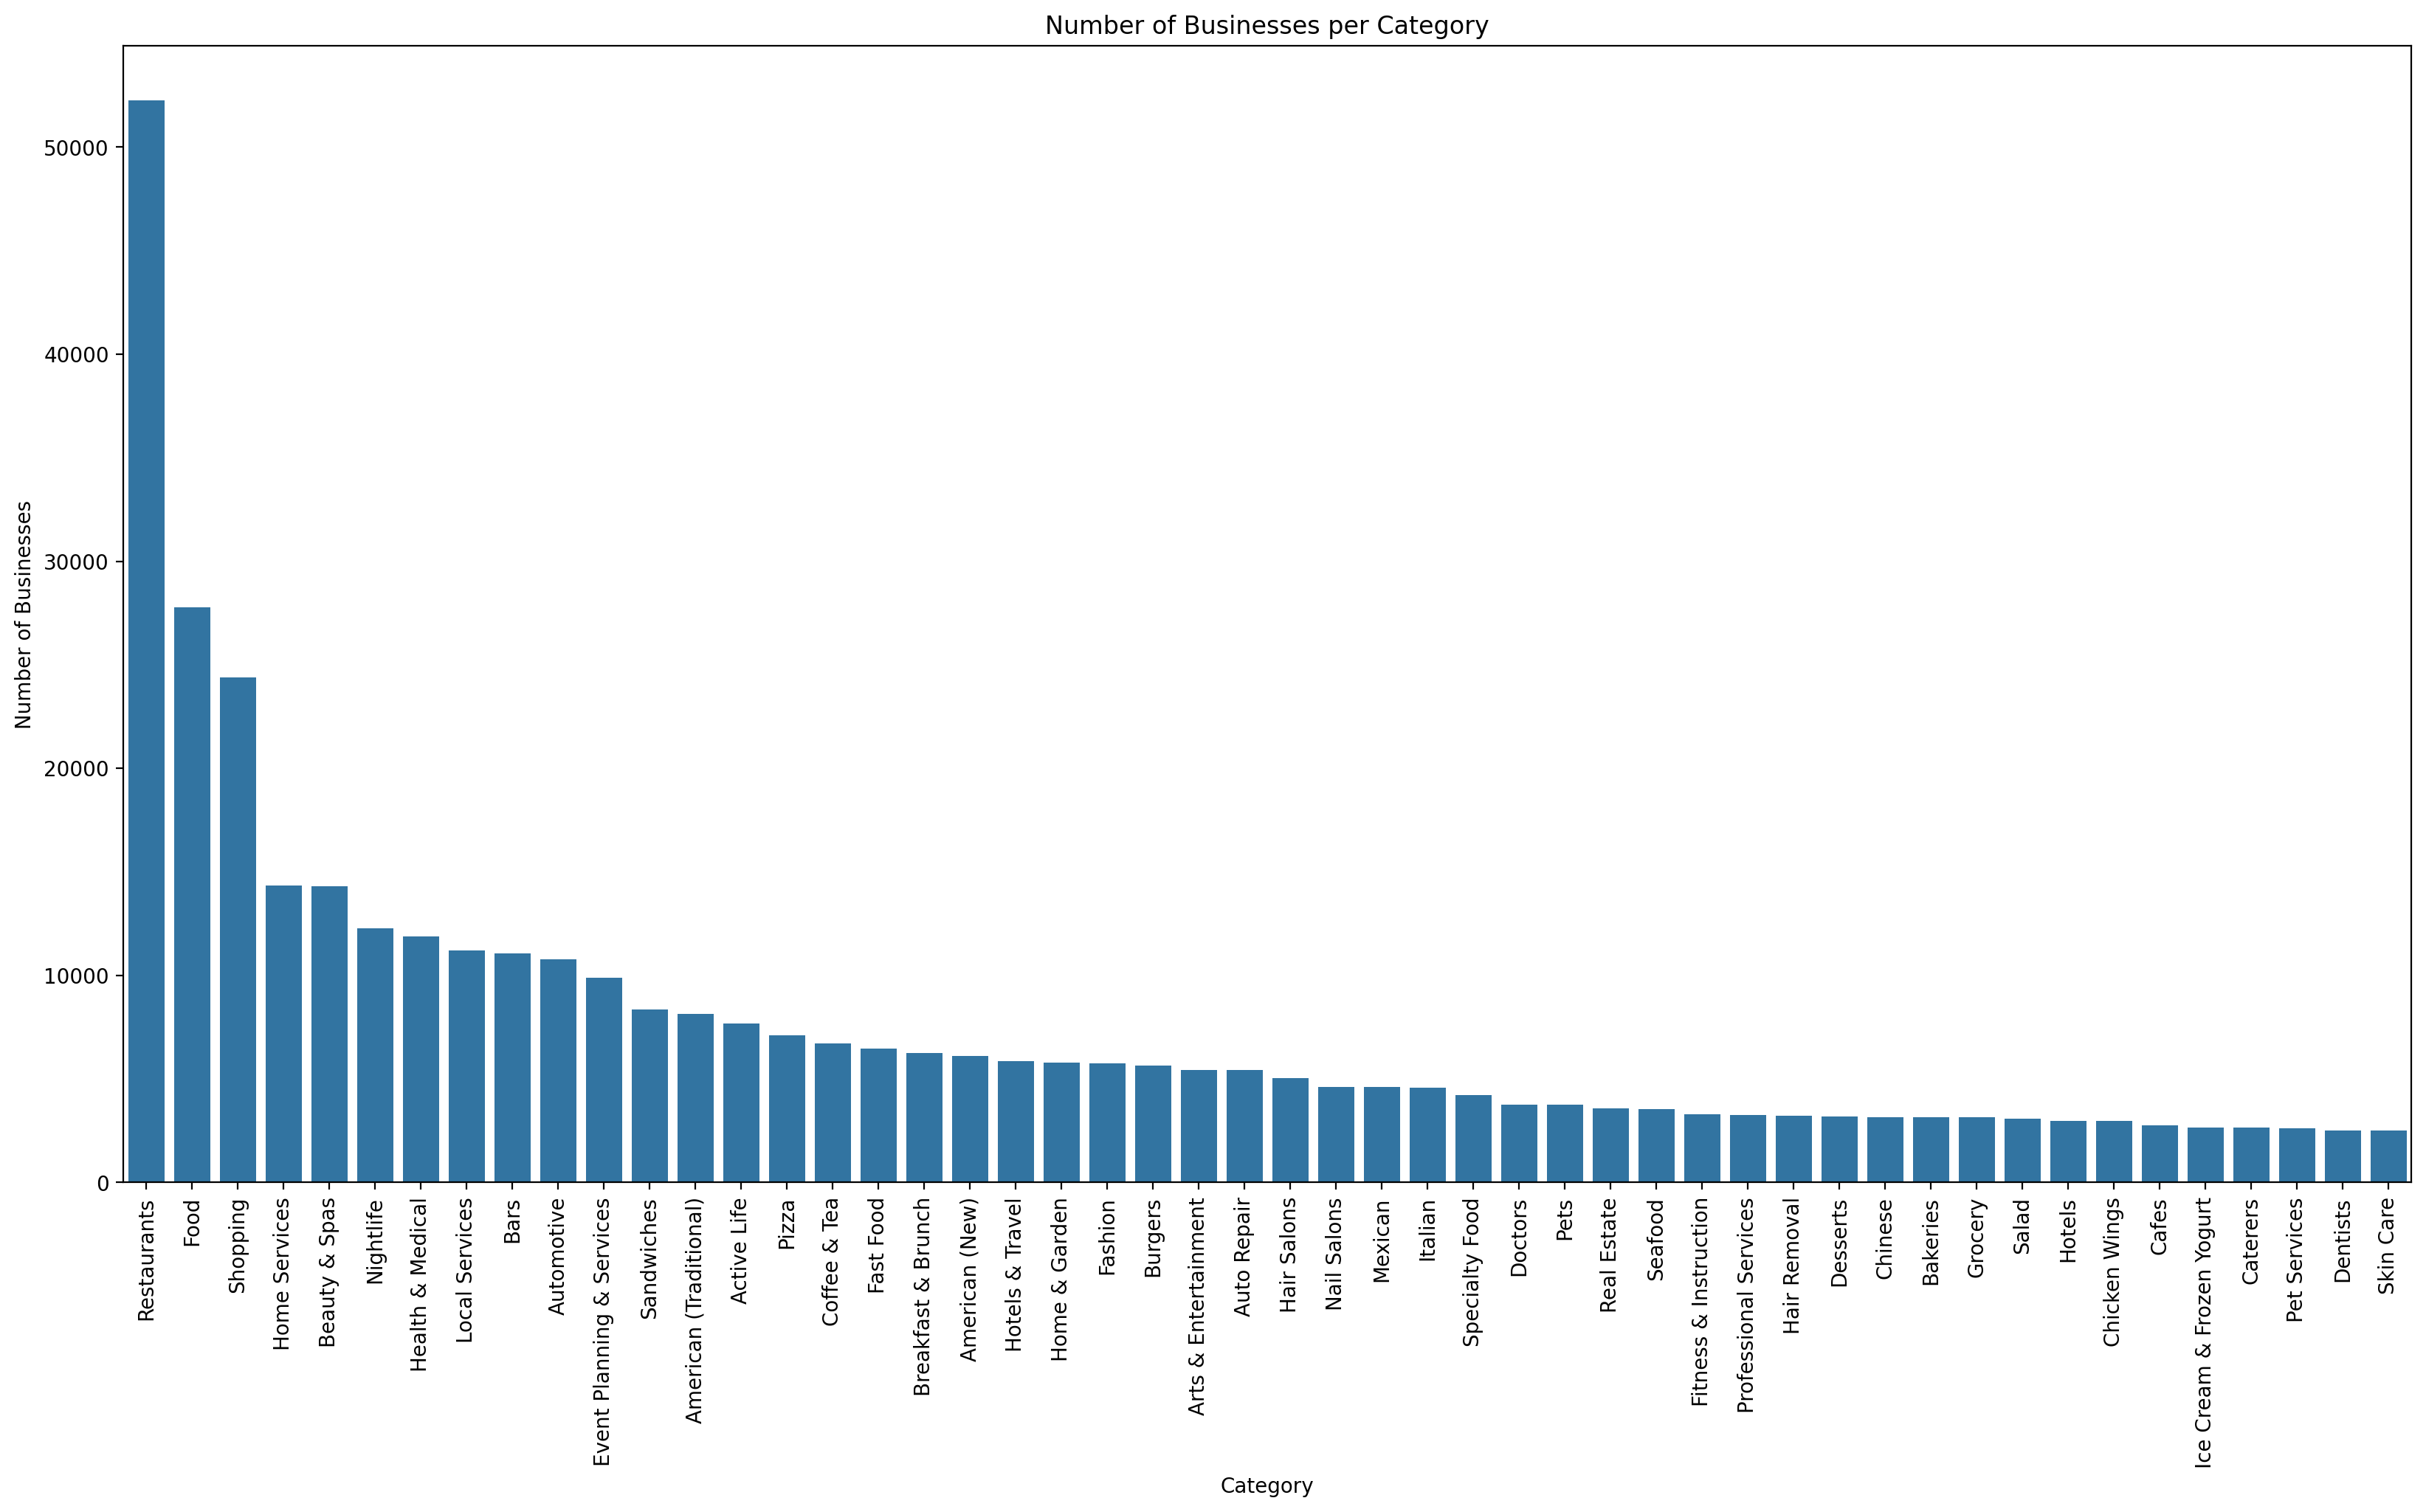

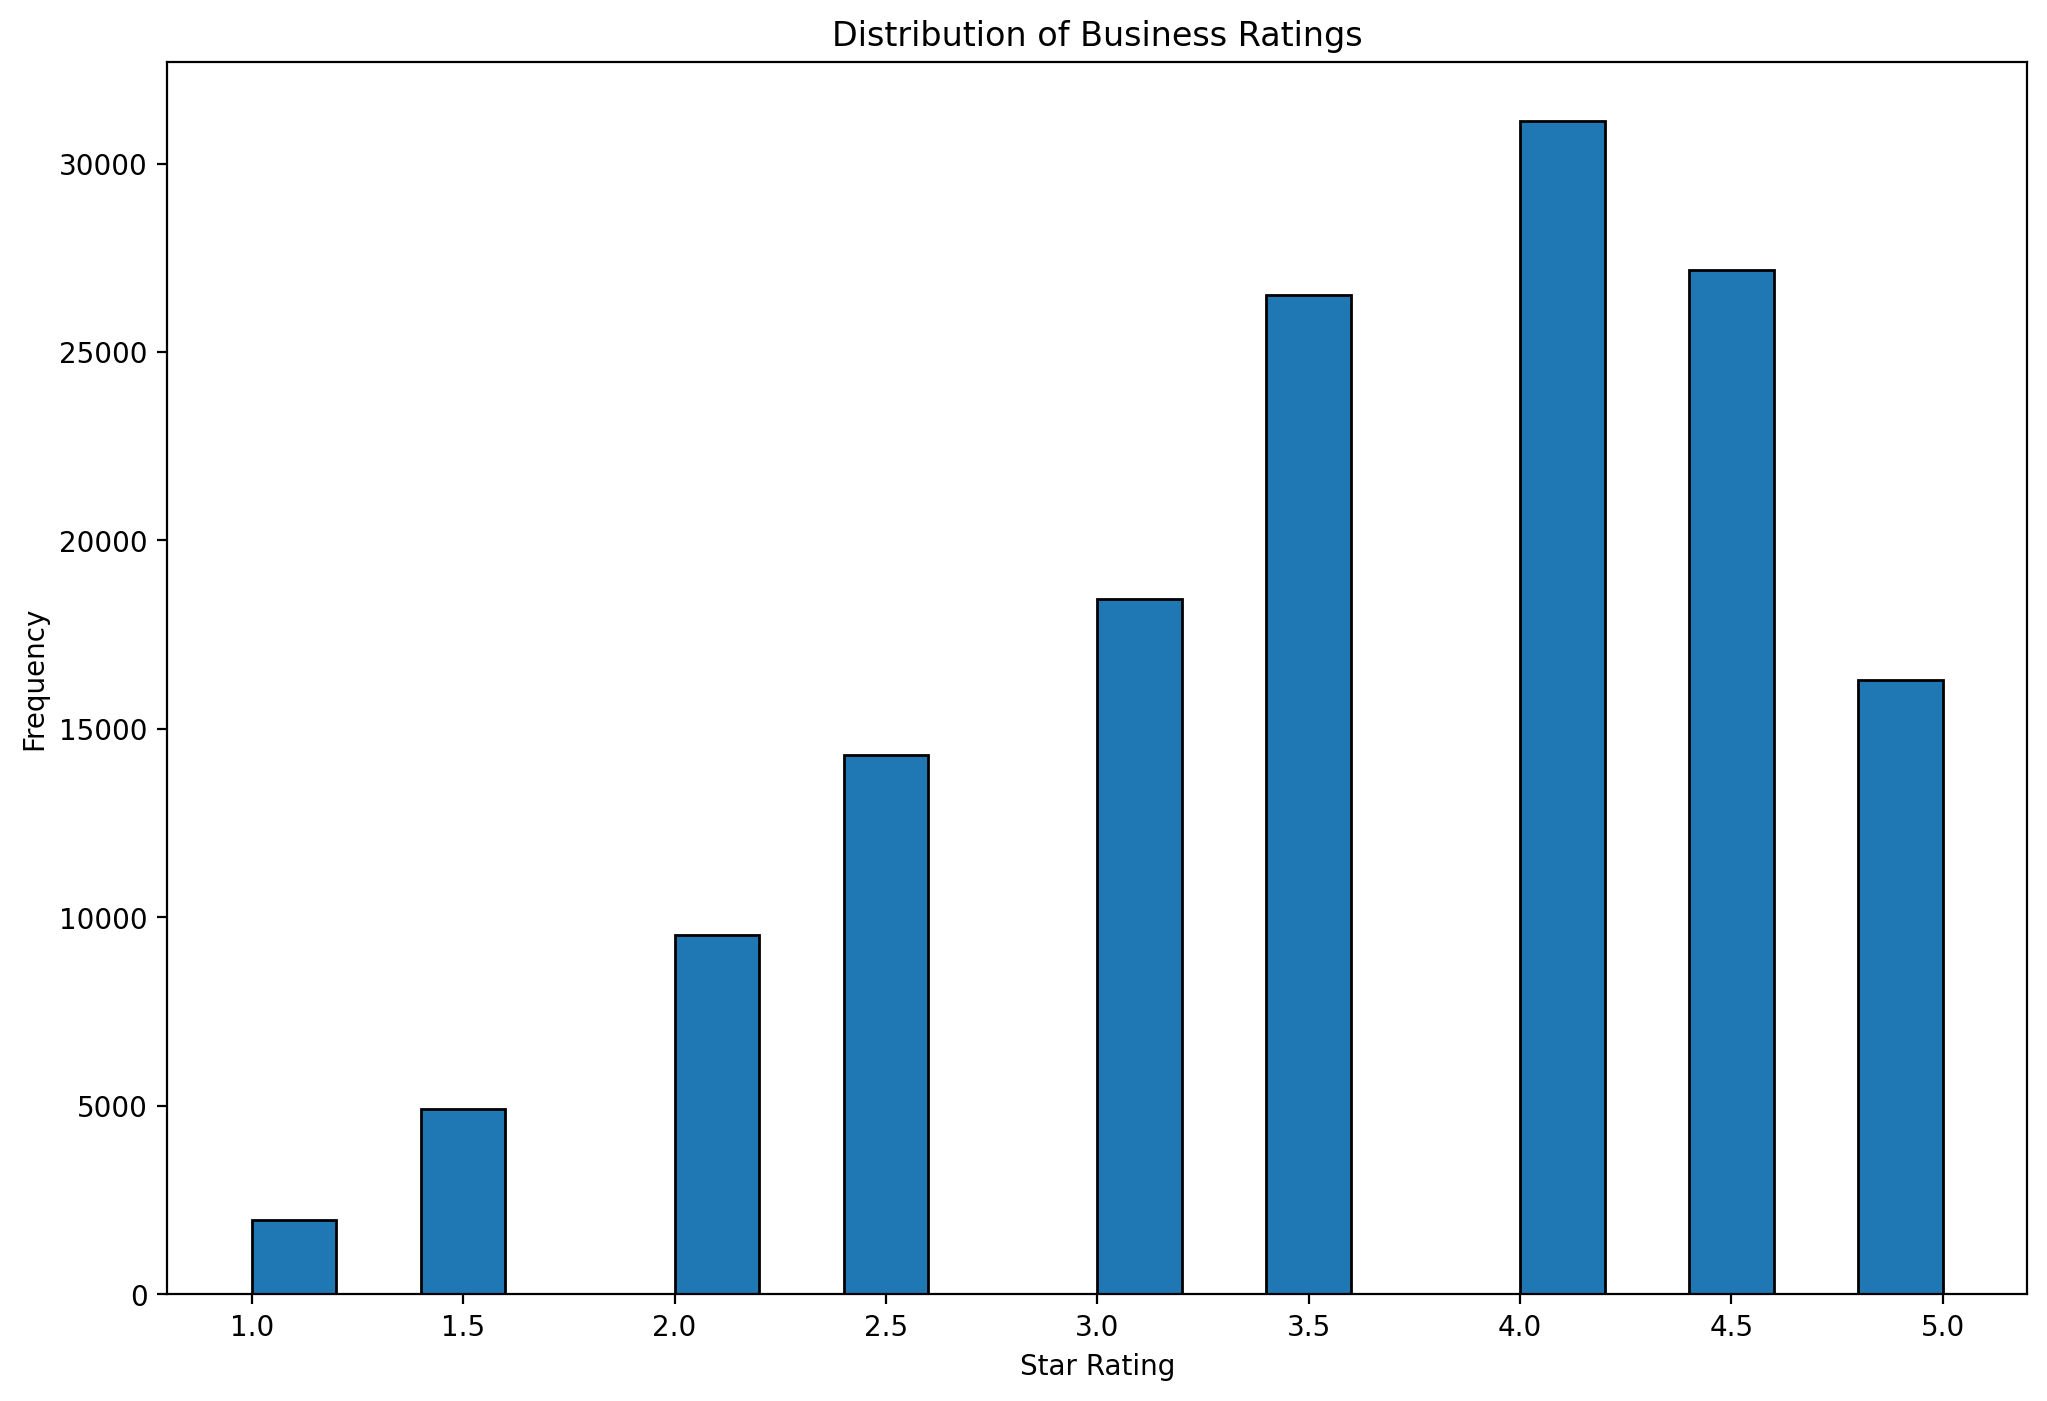

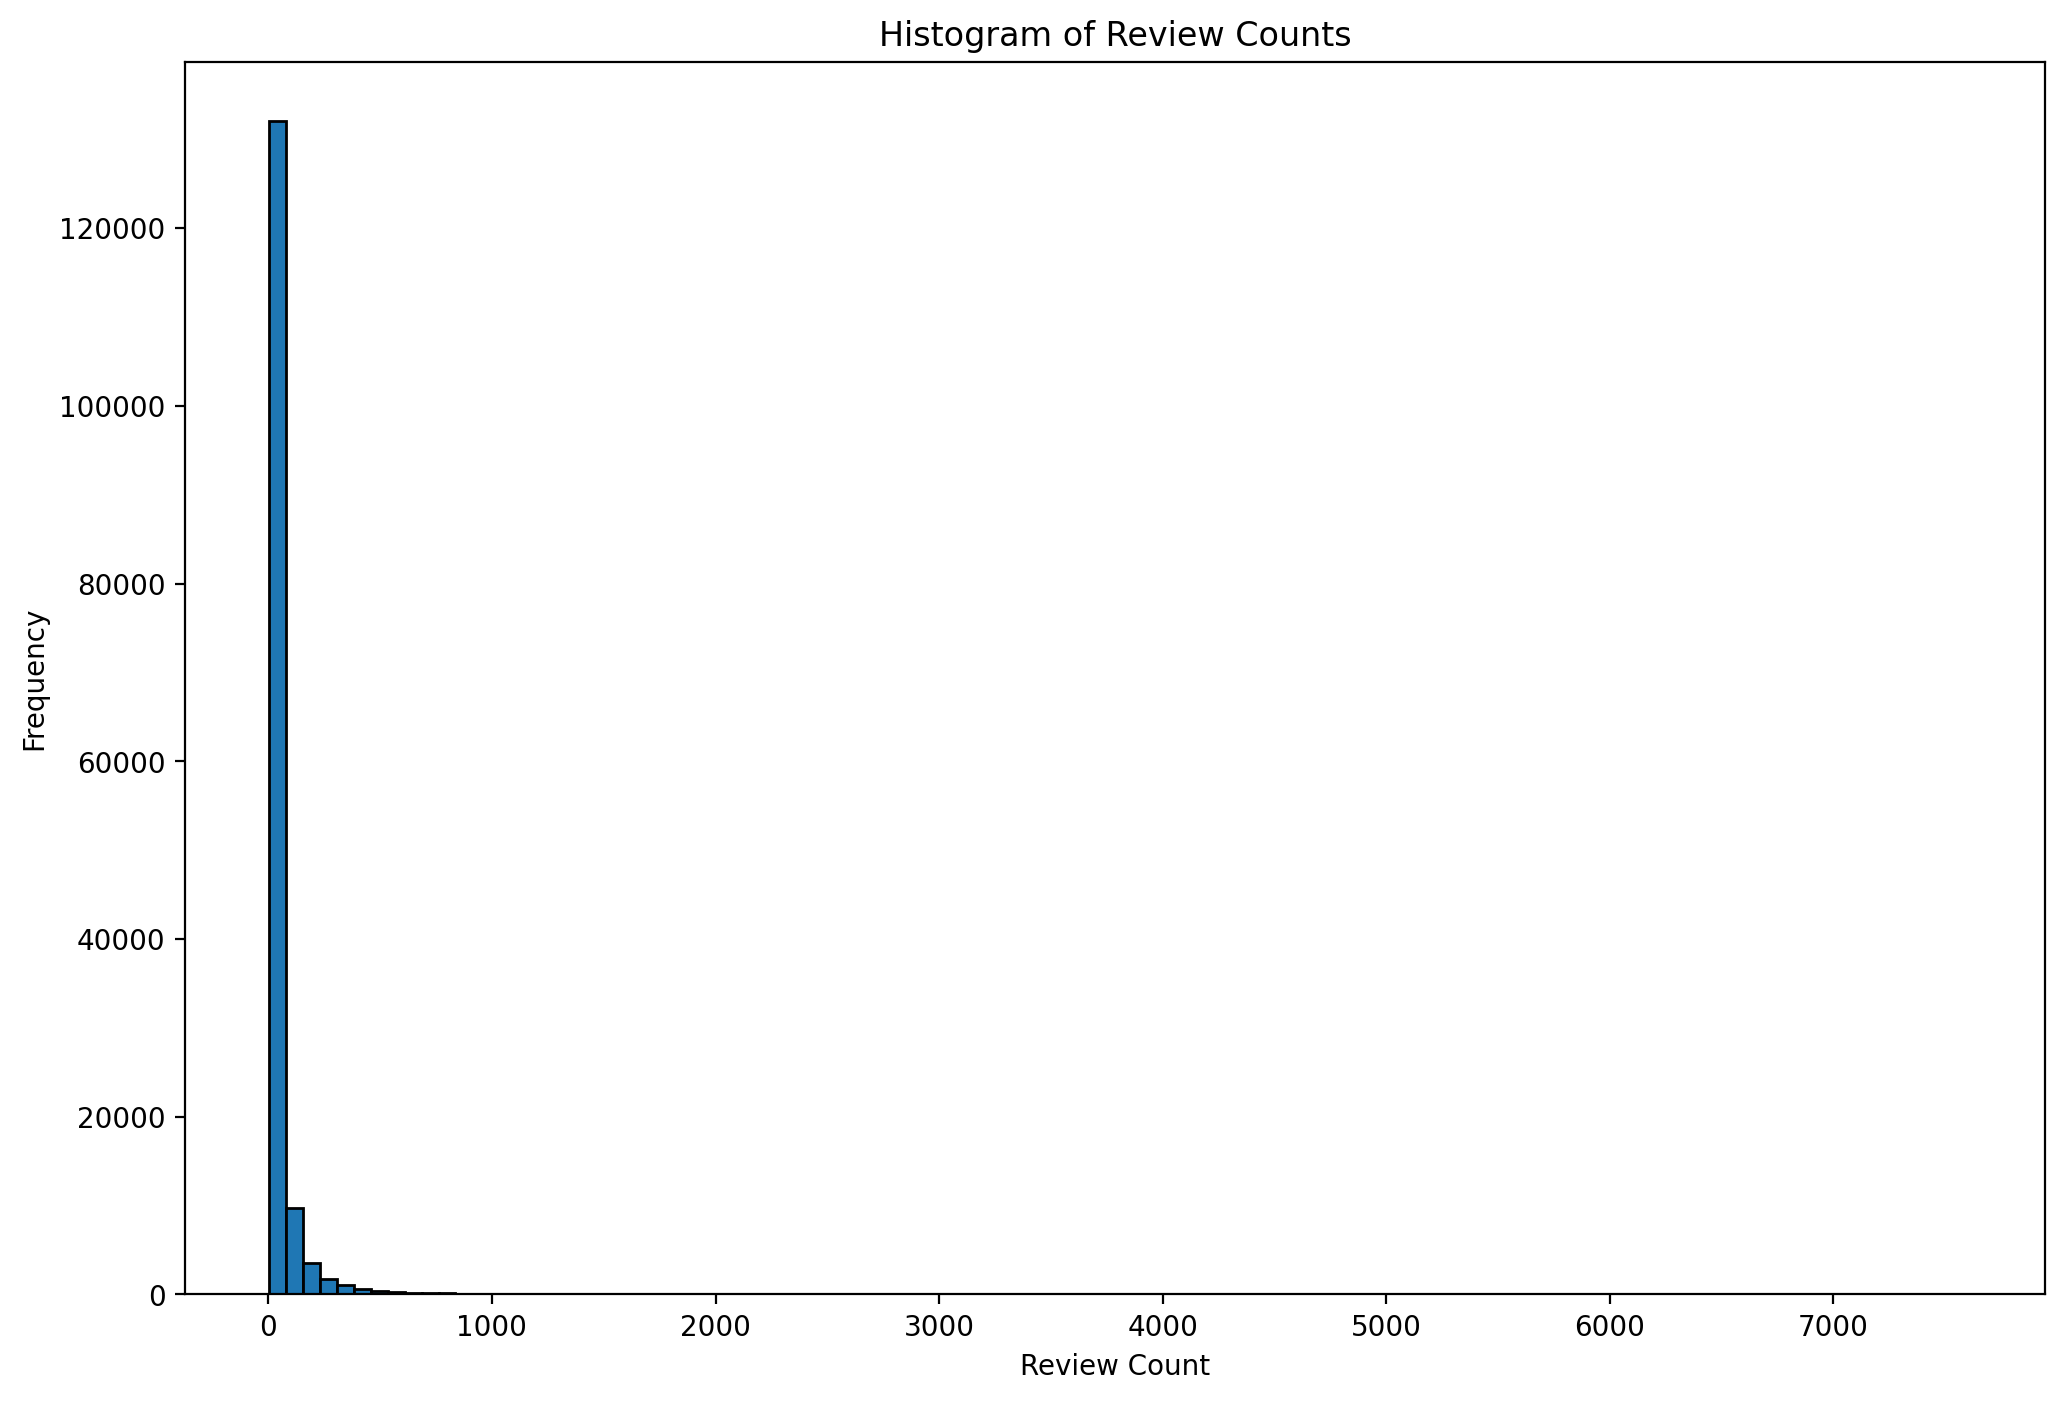

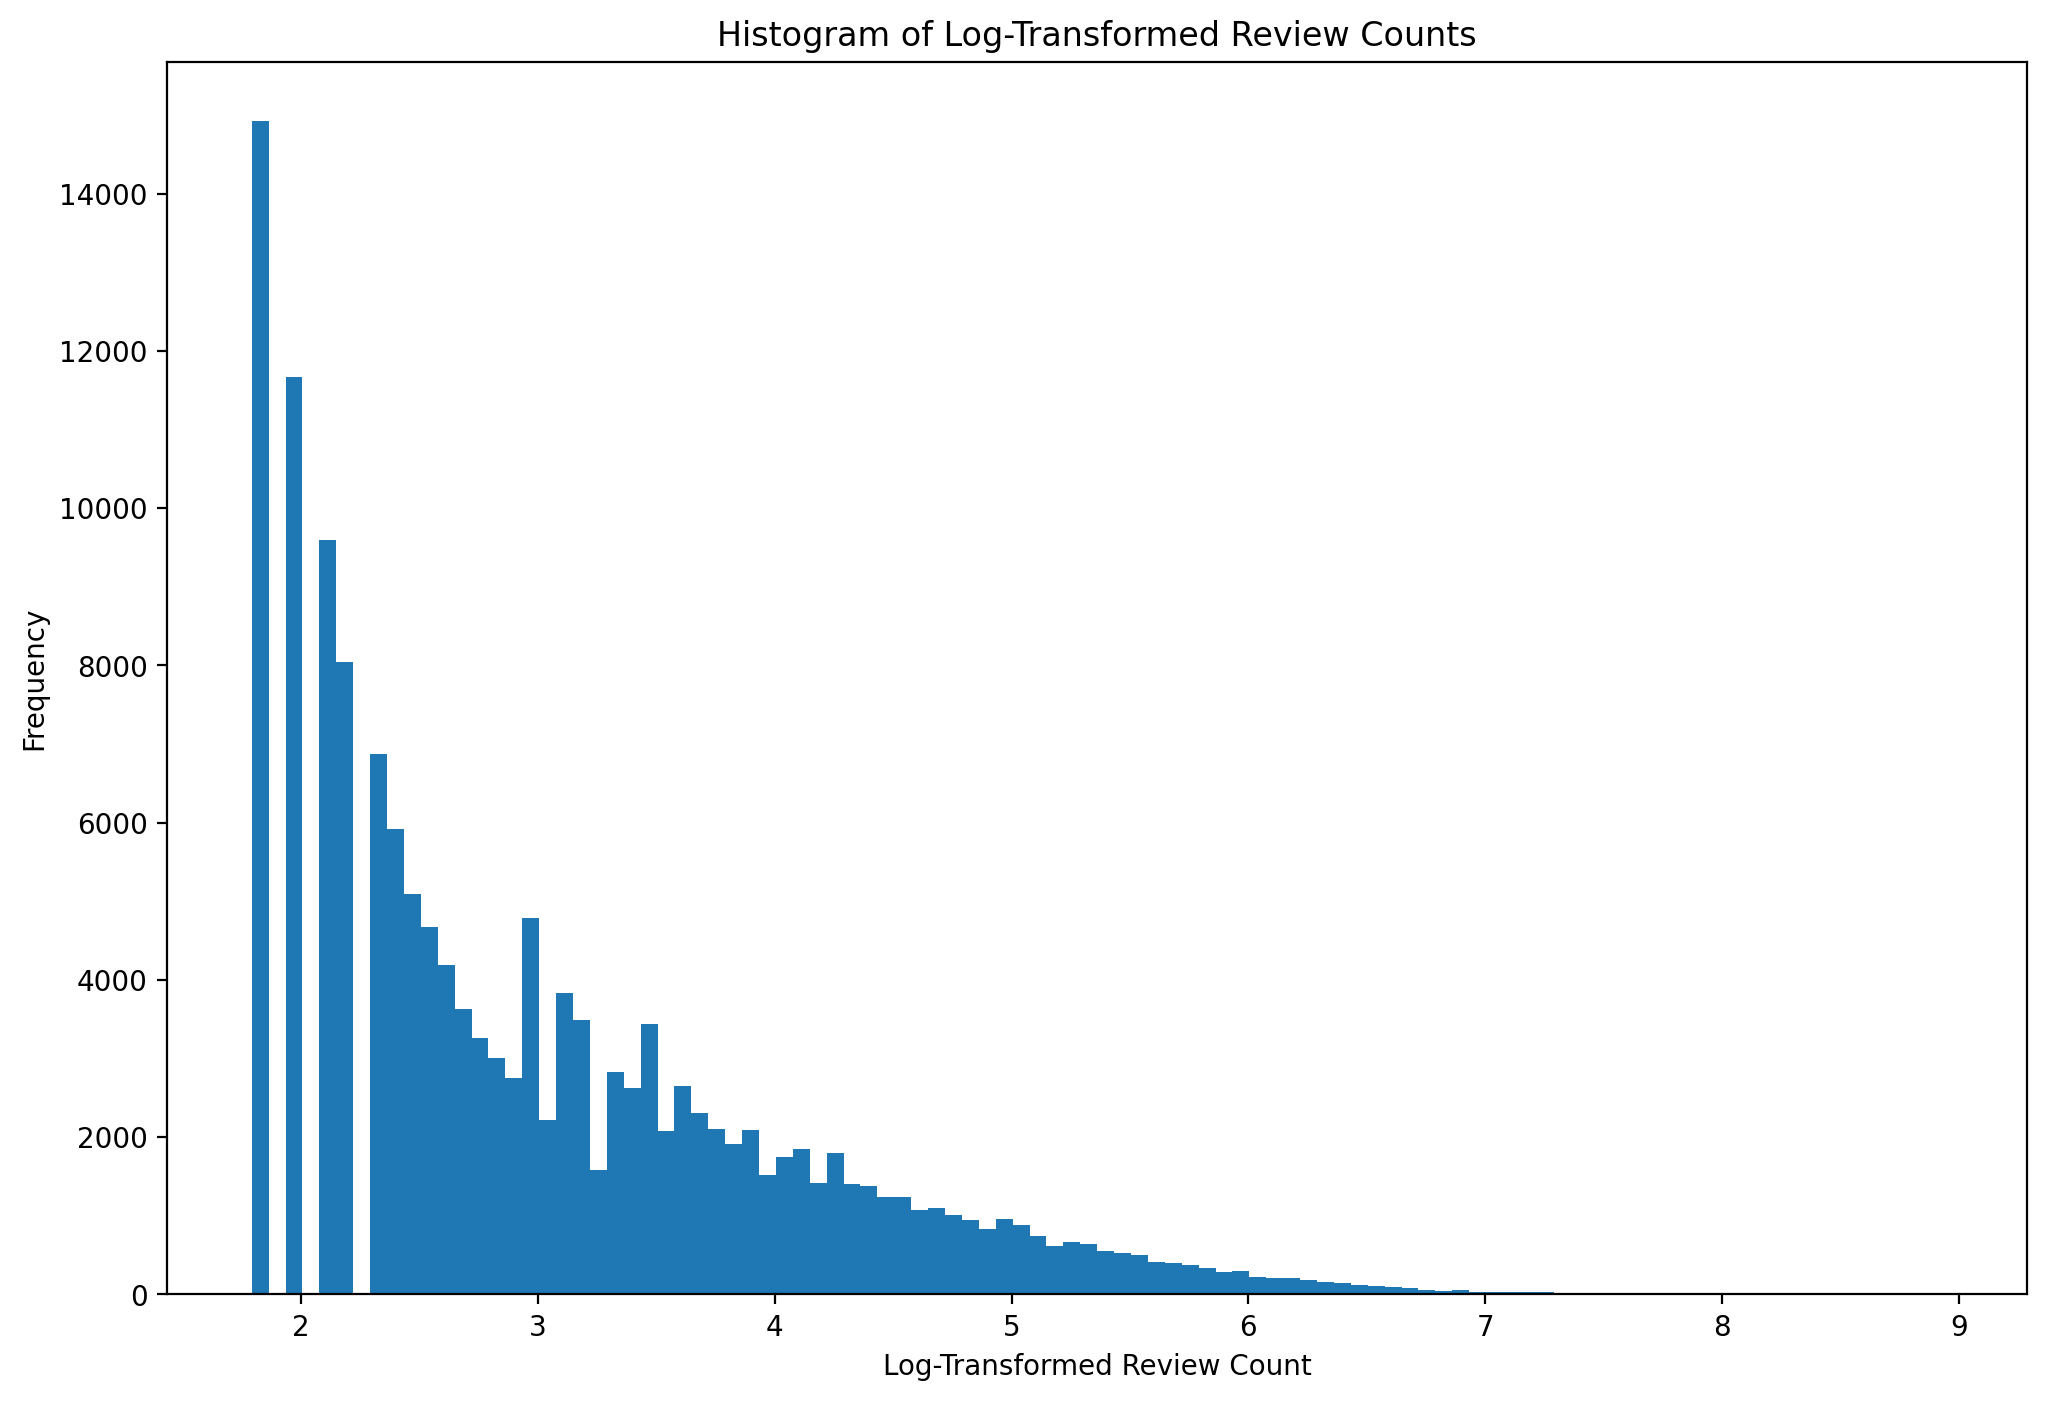

Finished processing bus_df

Processing tip_df:


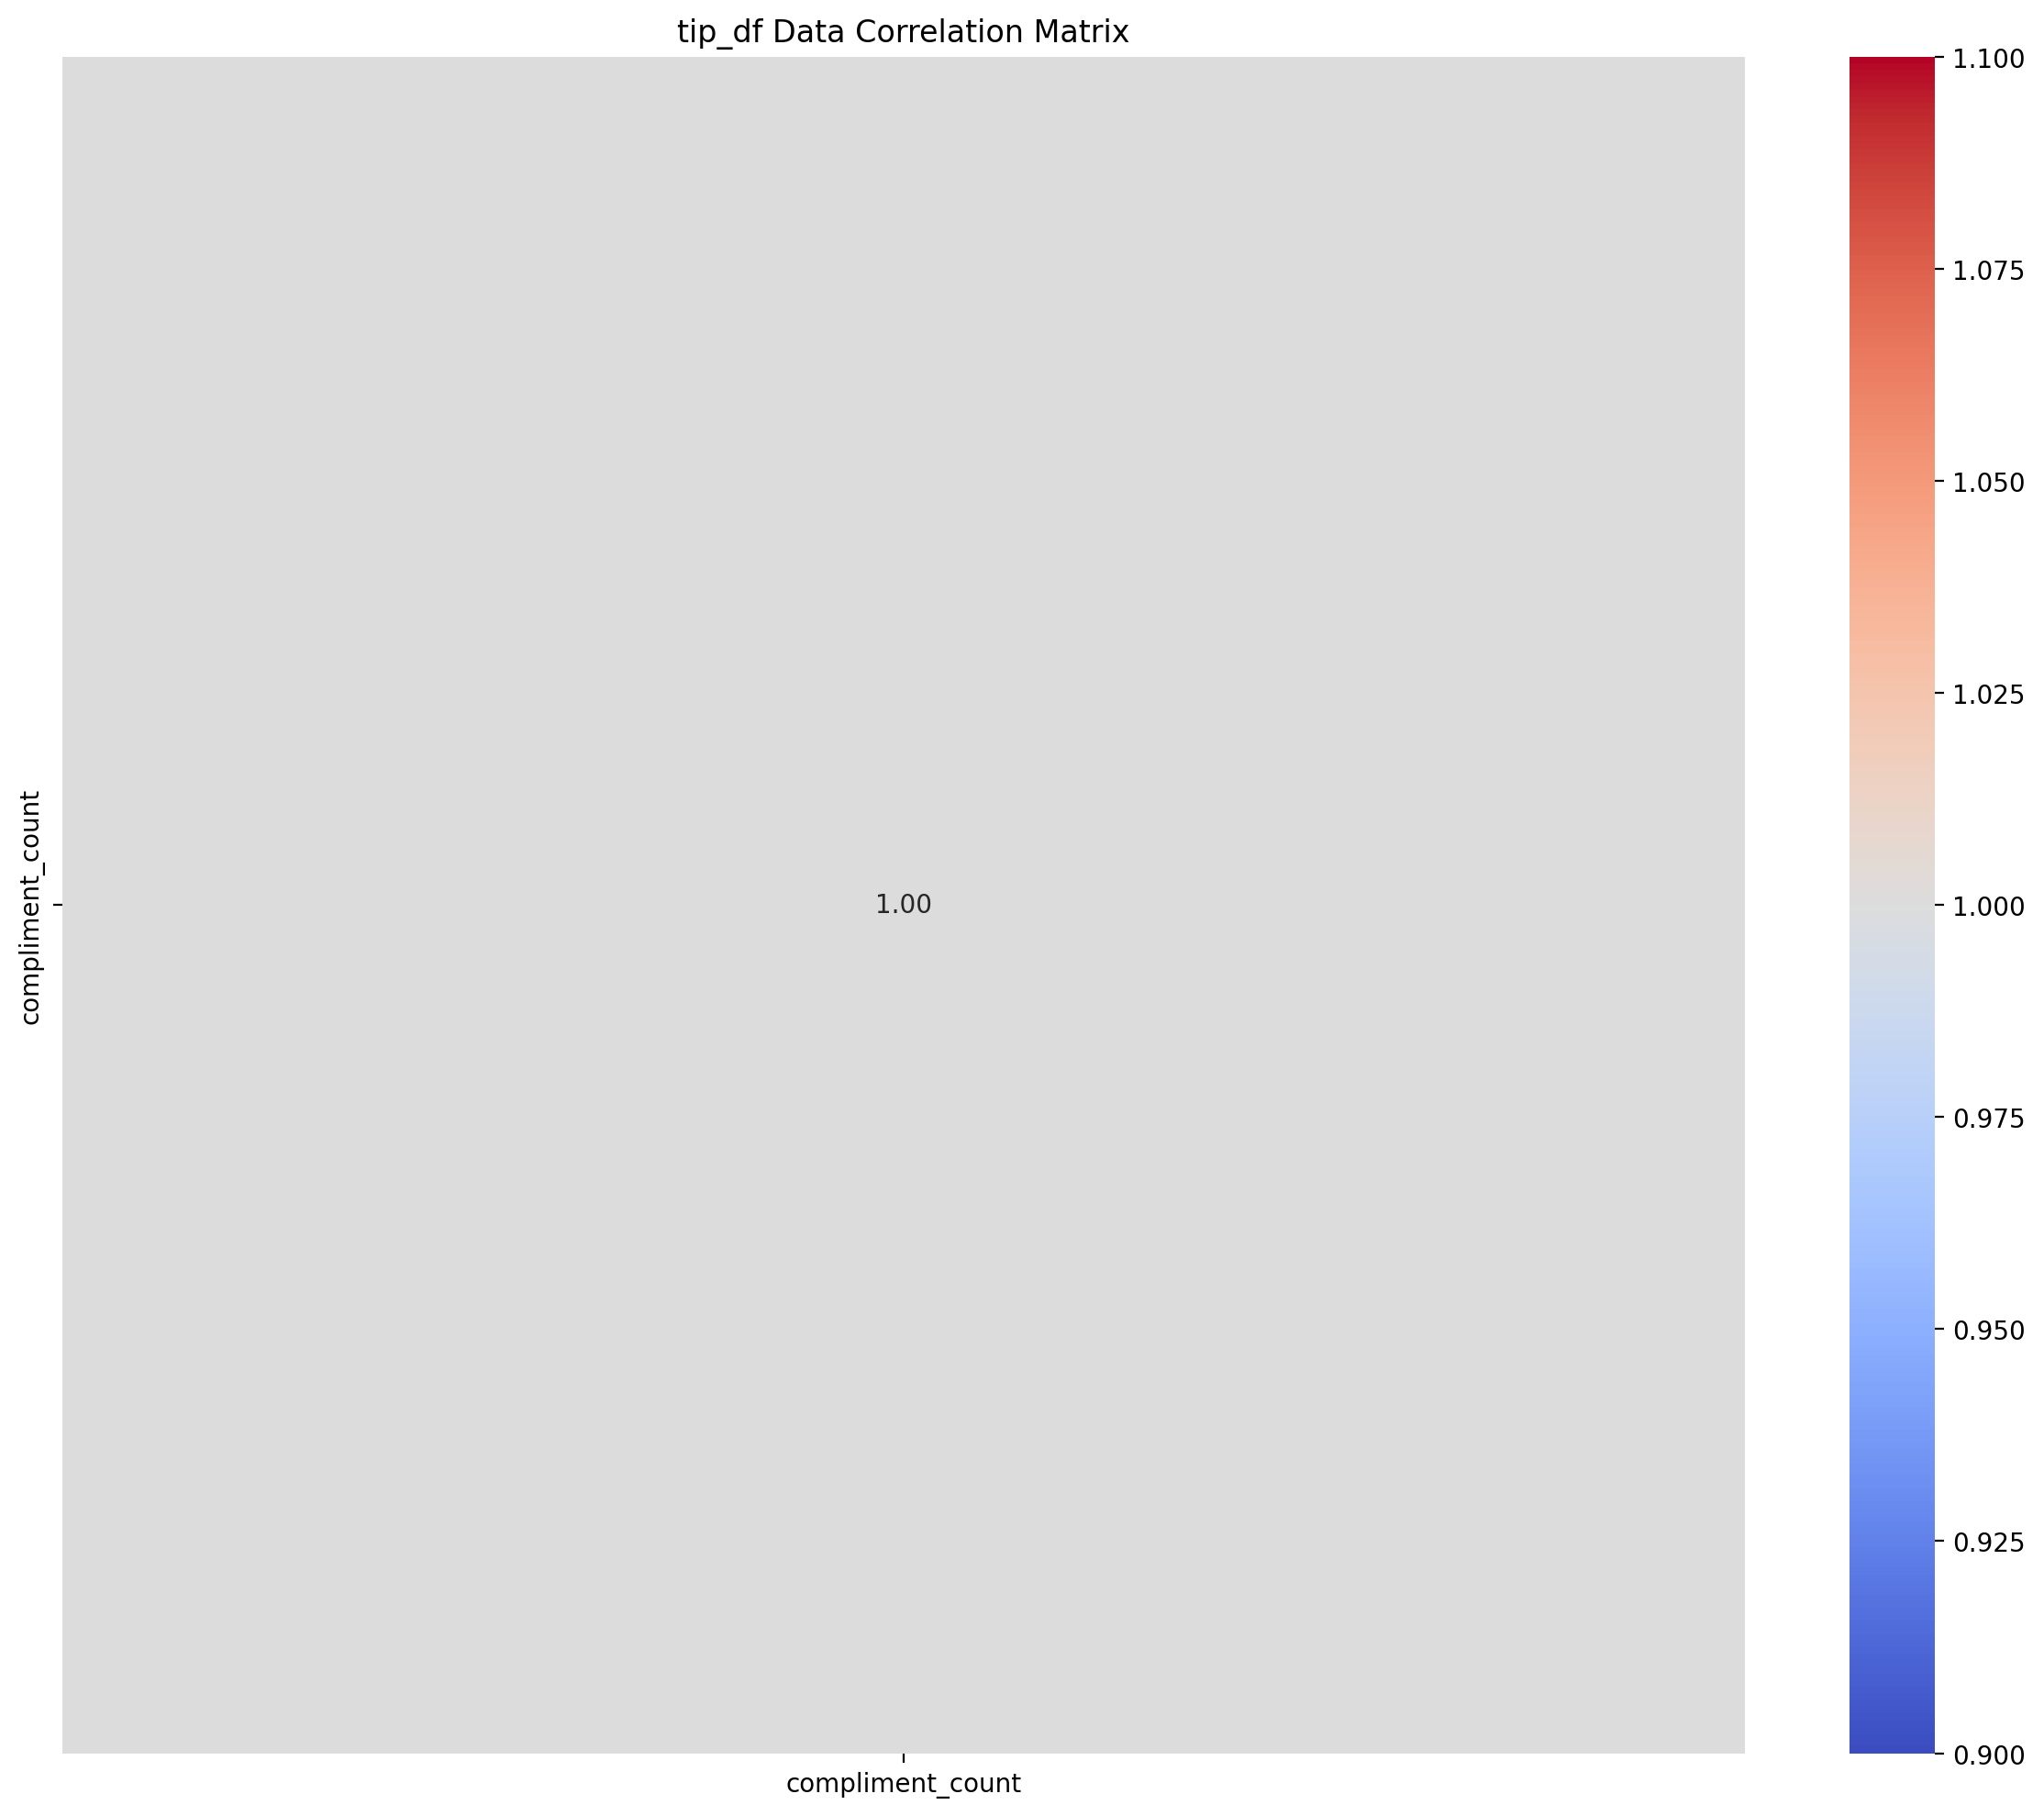

Finished processing tip_df

Processing review_df:


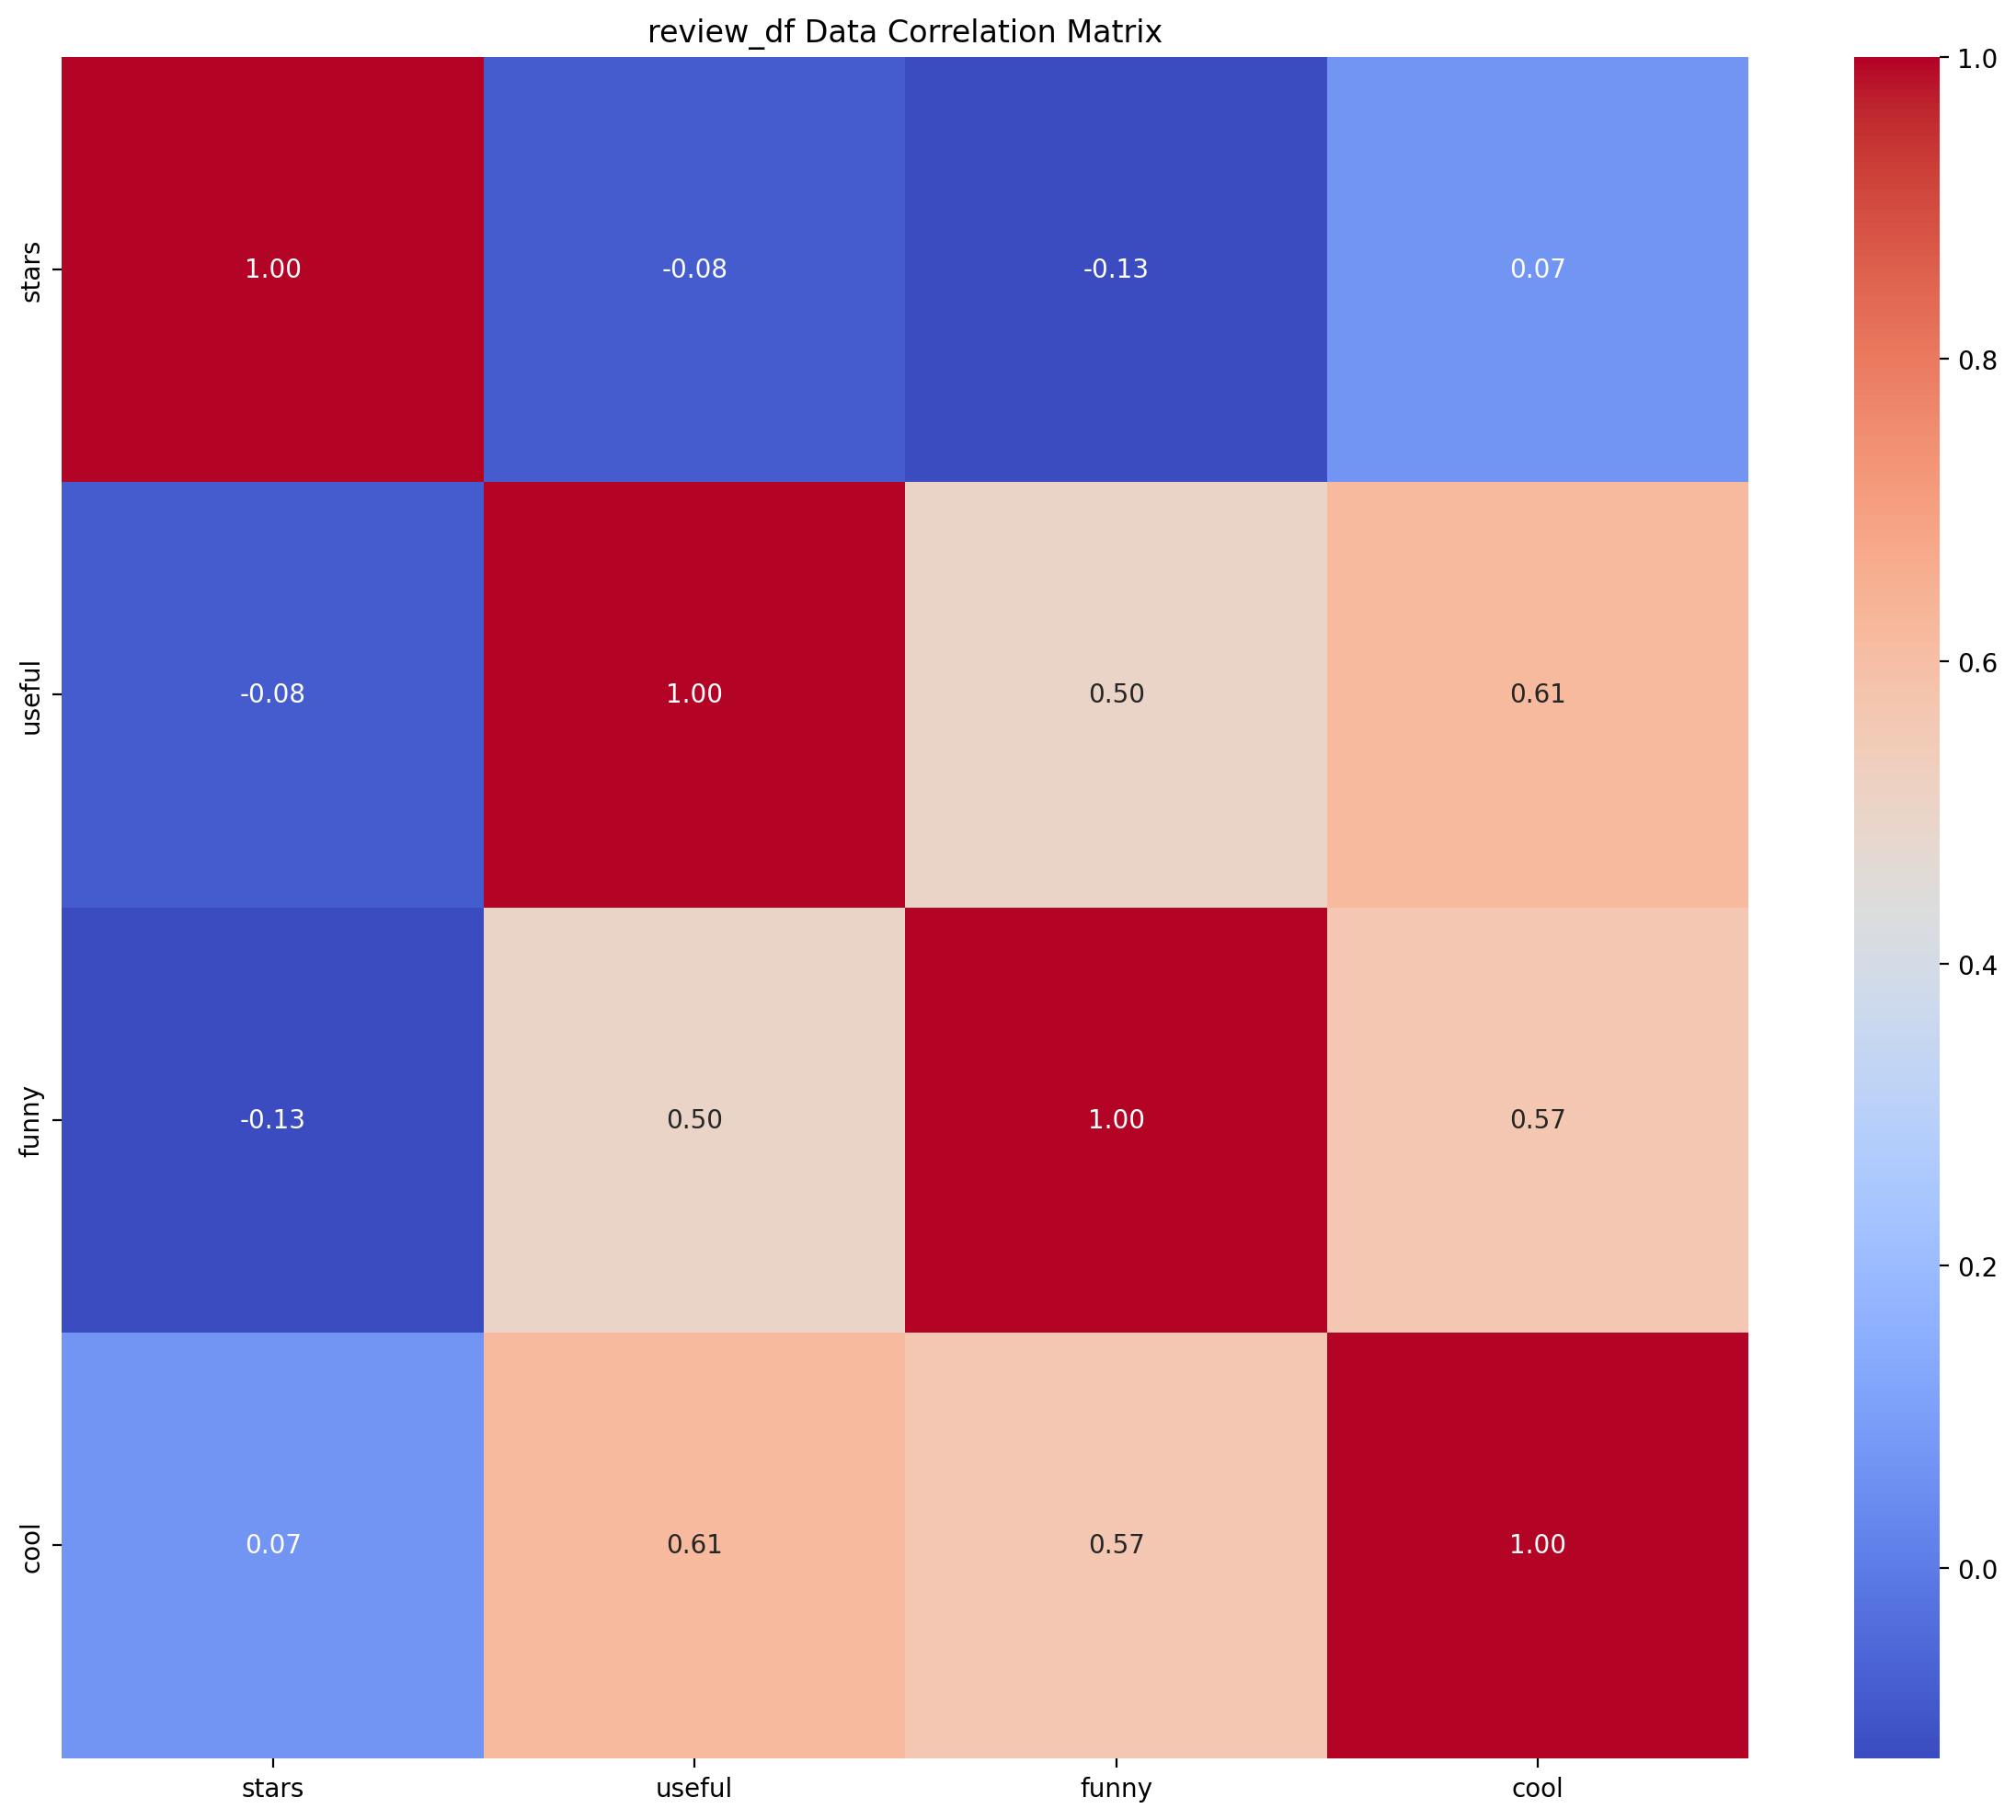

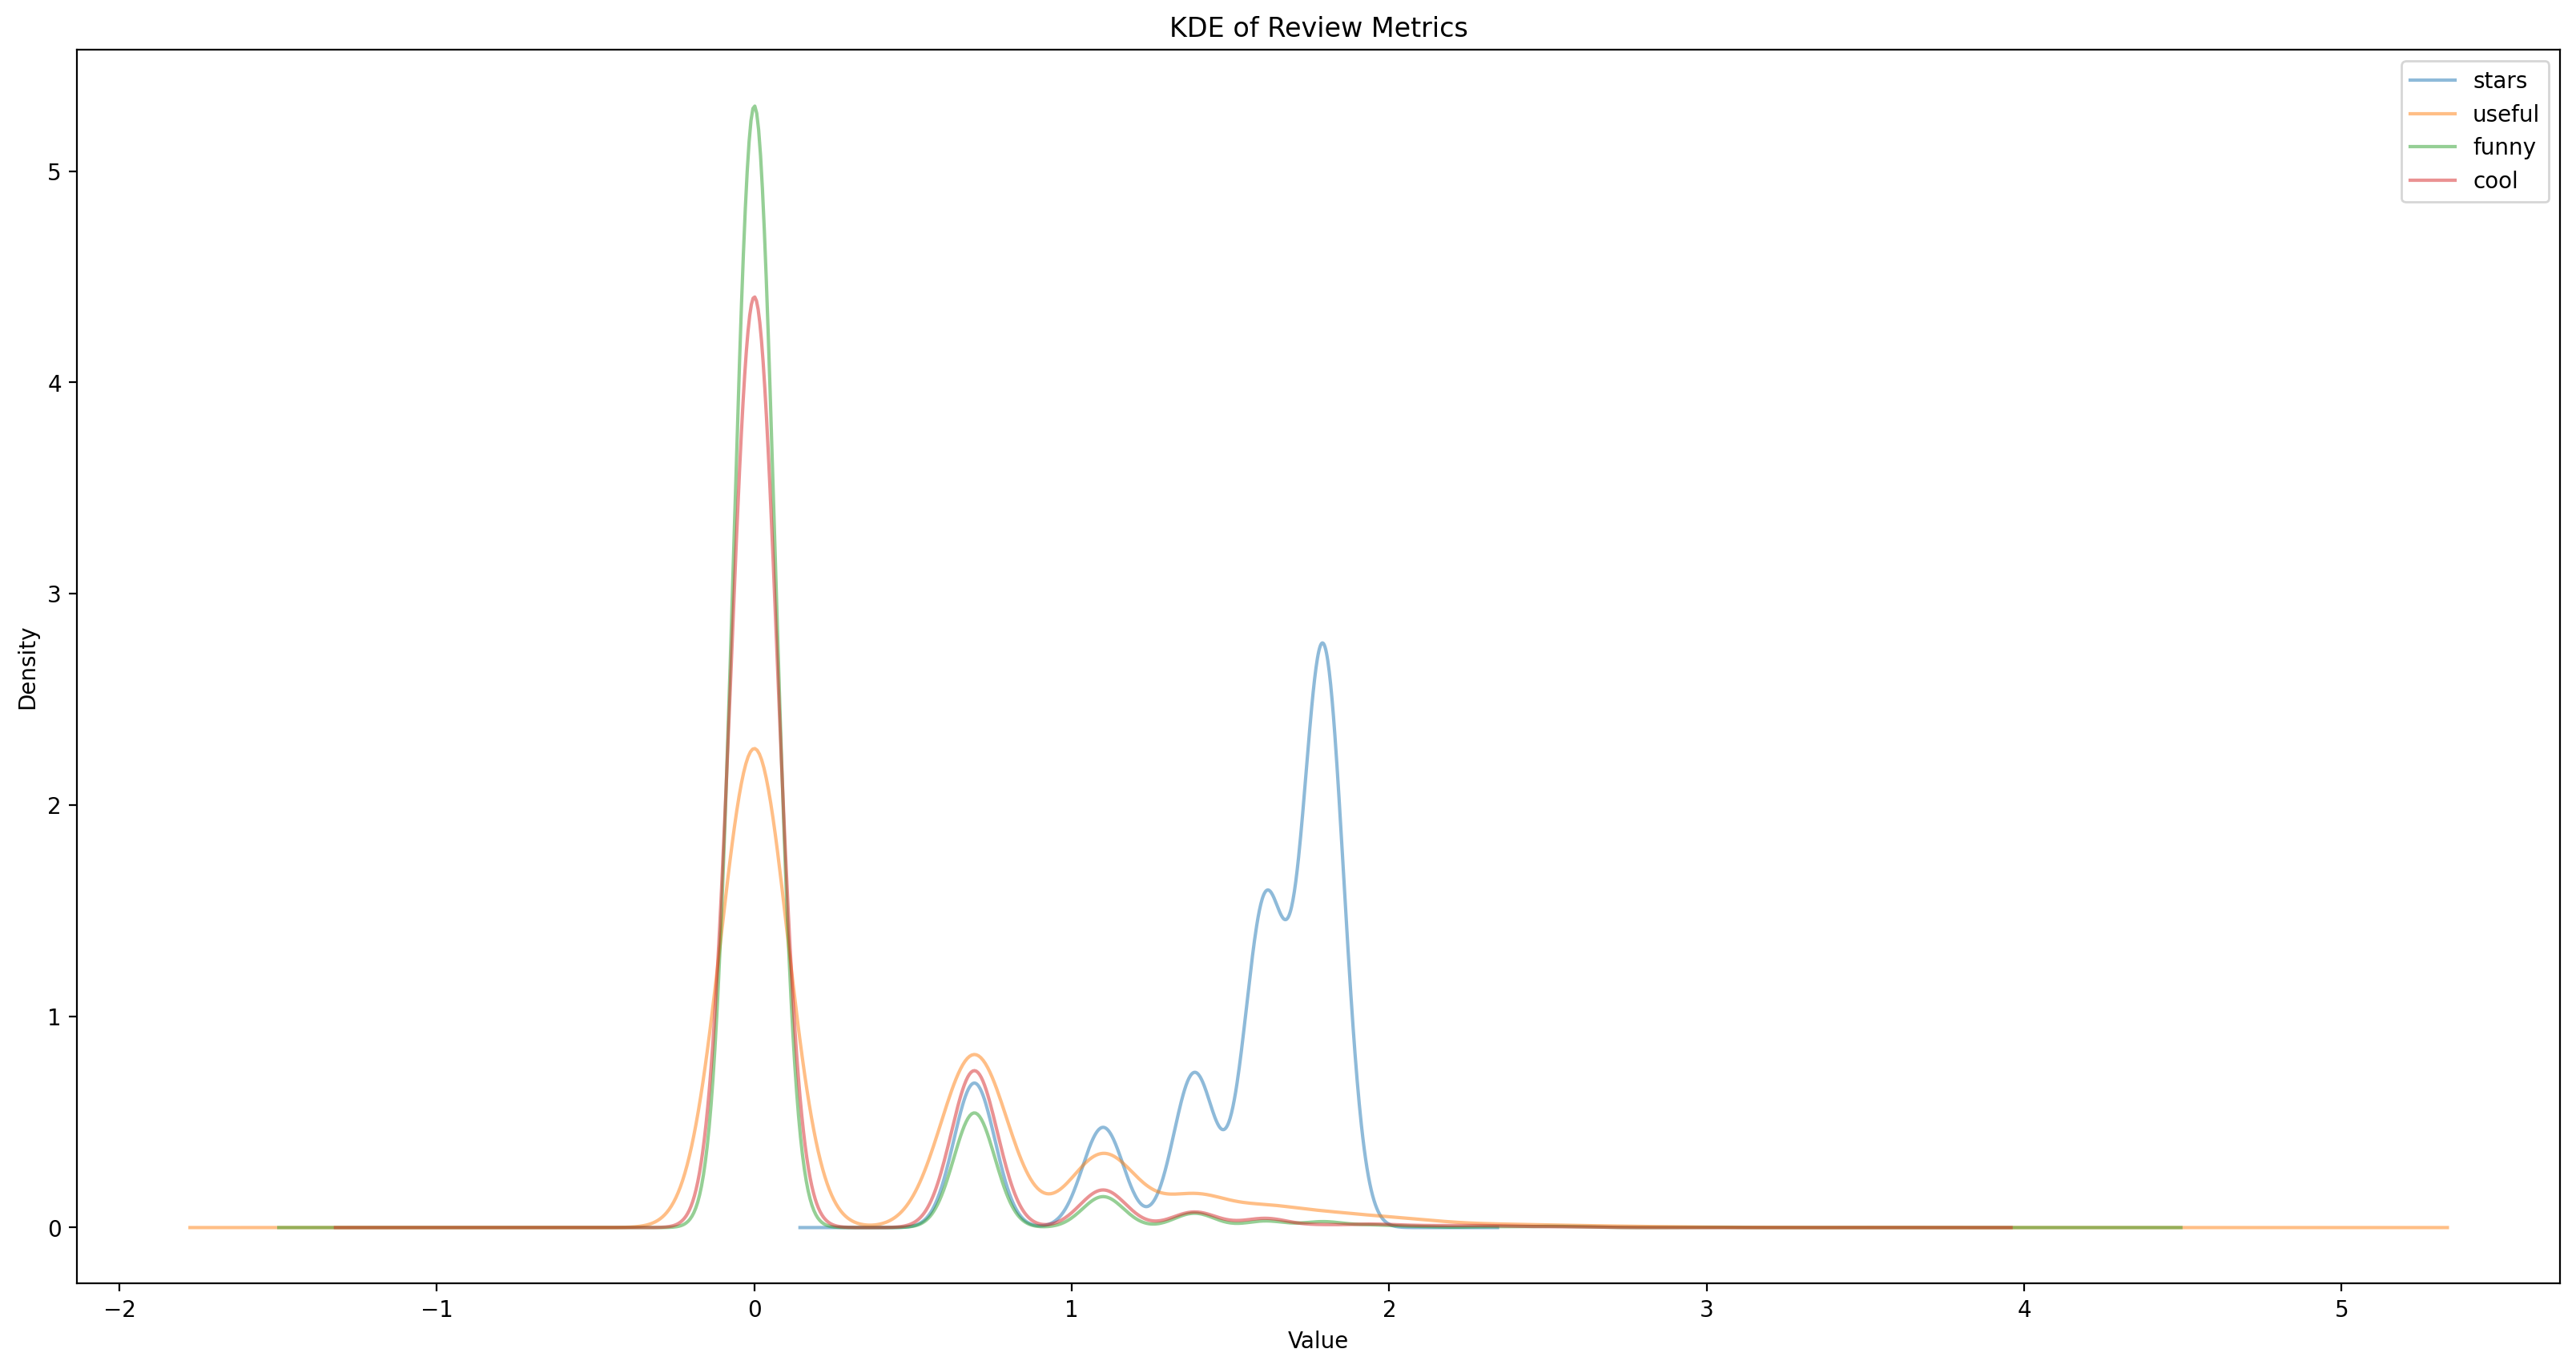

Finished processing review_df

Processing user_df:


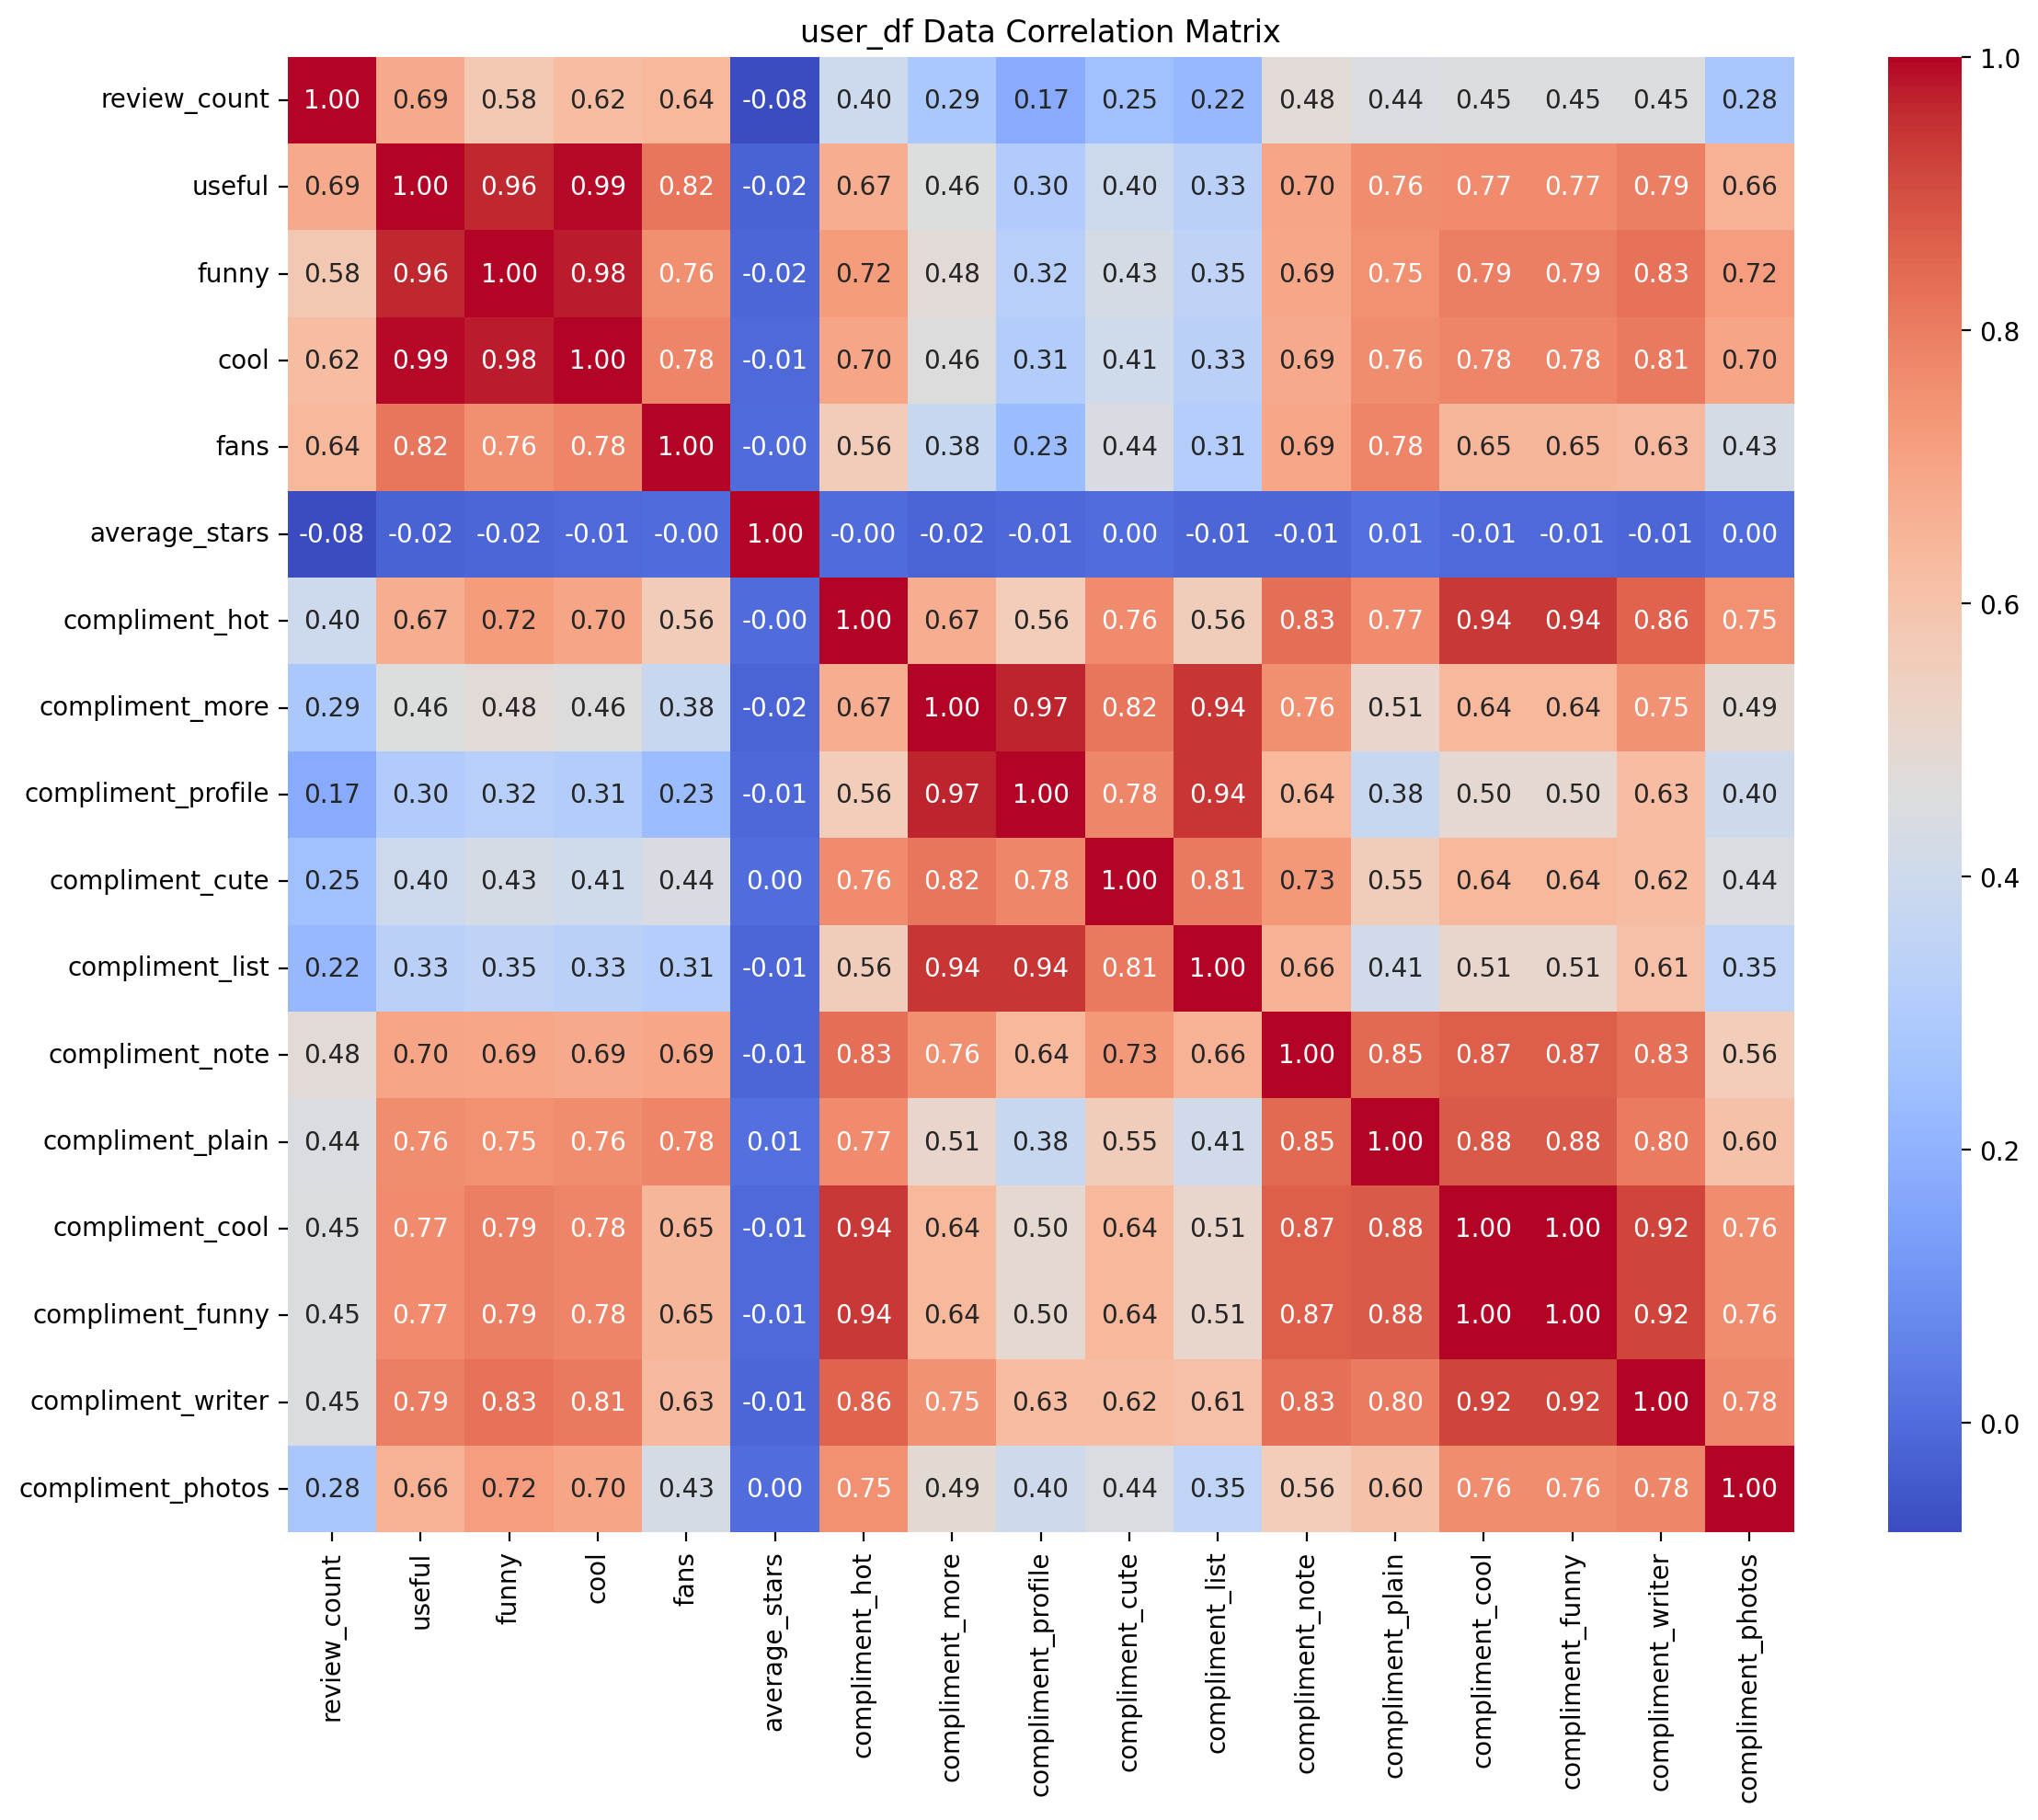

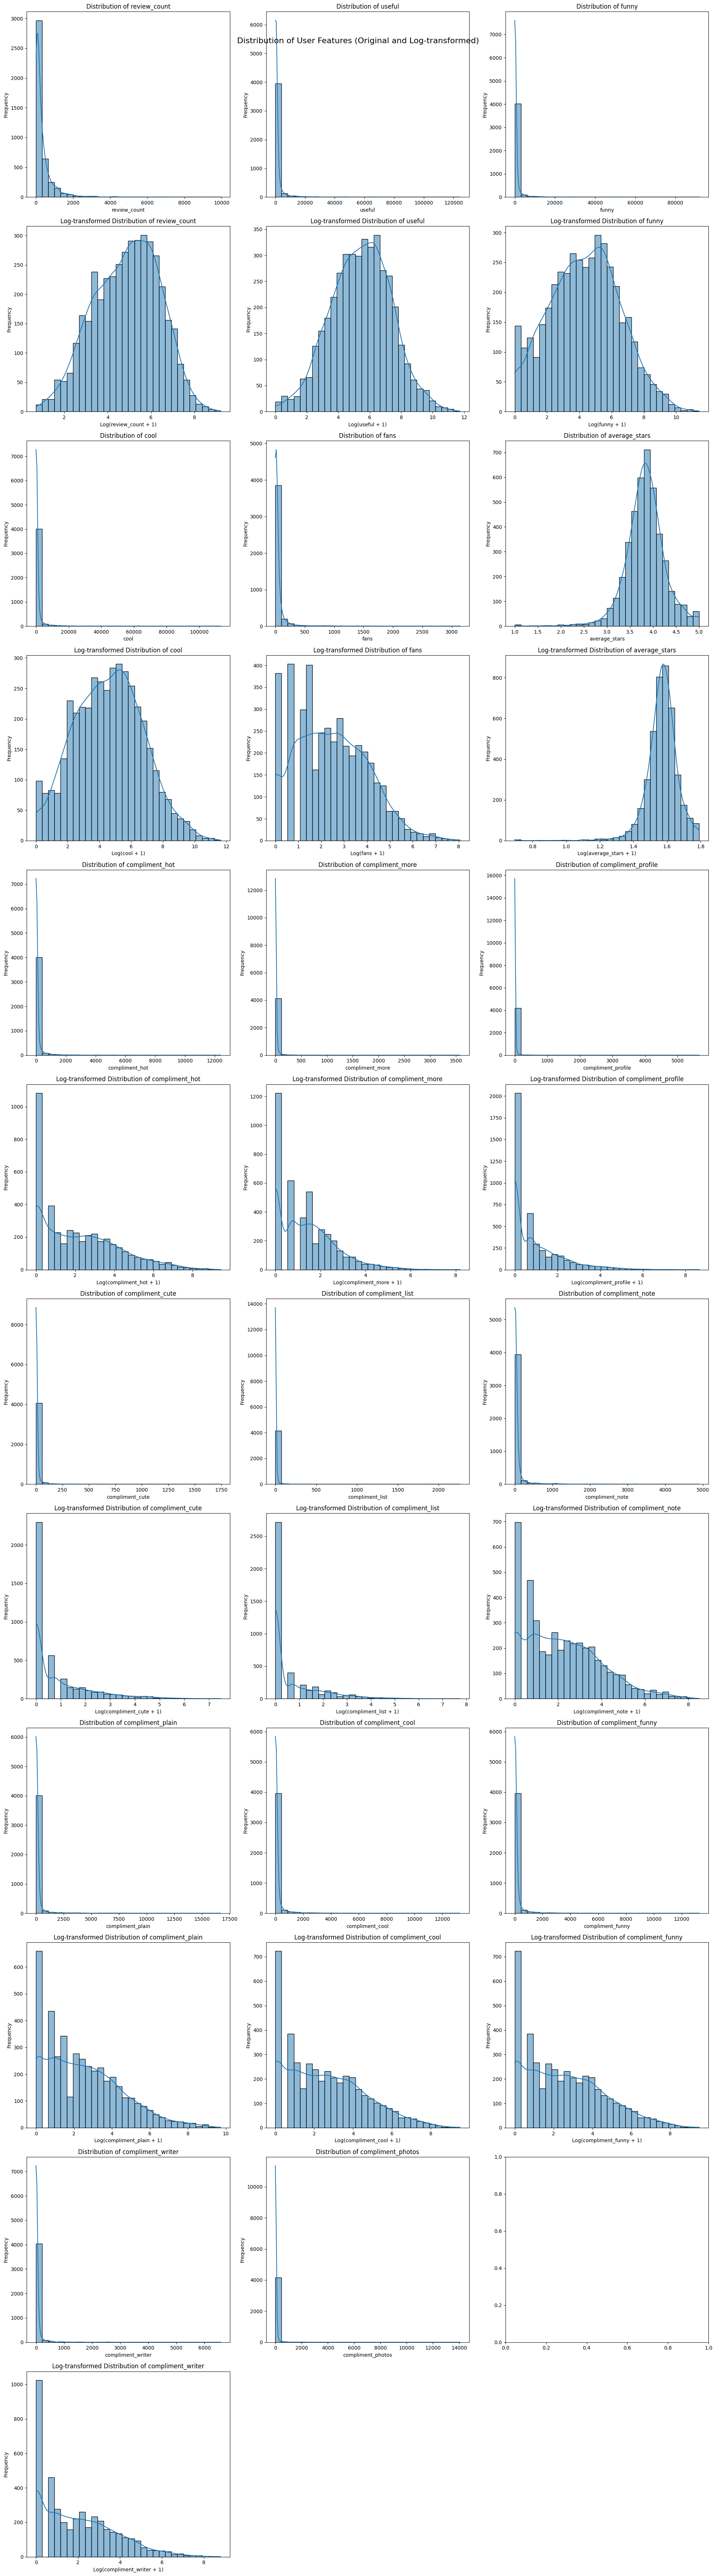

Finished processing user_df


In [96]:
def compute_and_plot_correlation(data, title):
    corr = data.corr(numeric_only=True).compute()
    plt.figure(figsize=(12, 10), dpi=200)
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'{title} Correlation Matrix')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}_correlation.png', dpi=200)
    plt.show()

def plot_kde(data, columns, title, xlabel, ylabel):
    data.loc[:, columns].compute().plot.kde()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(f'{title.lower().replace(" ", "_")}.png', dpi=200)
    plt.show()

def plot_histogram(data, column, title, xlabel, ylabel, bins=20, log_transform=False):
    plt.figure(figsize=(12, 8), dpi=200)
    data_computed = data.loc[:, [column]].compute()
    
    if log_transform:
        data_computed['log_' + column] = np.log1p(data_computed[column])
        plt.hist(data_computed['log_' + column], bins=bins)
        xlabel = f'Log-Transformed {xlabel}'
    else:
        plt.hist(data_computed[column], bins=bins, edgecolor='black')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(f'{title.lower().replace(" ", "_")}.png', dpi=200)
    plt.show()

def plot_review_metrics_kde(data, columns):
    data_review = data.loc[:, columns].compute()
    data_review_log = np.log1p(data_review)
    
    fig, ax = plt.subplots(figsize=(20, 10), dpi=200)
    data_review_log.plot.kde(ax=ax, alpha=0.5)
    ax.set_title('KDE of Review Metrics')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    plt.savefig('review_metrics_kde.png', dpi=200)
    plt.show()

def plot_geographical_distribution(data):
    businesses = data.compute()
    plt.figure(figsize=(10, 8), dpi=200)
    plt.scatter(businesses['longitude'], businesses['latitude'], alpha=0.5, c='blue', s=10)
    plt.title('Geographical Distribution of Businesses')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('geographical_distribution.png', dpi=200)
    plt.show()

def plot_category_counts(data):
    businesses = data.compute()
    category_counts = businesses['categories'].explode().value_counts().head(50)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.barplot(x=category_counts.index, y=category_counts.values)
    plt.title('Number of Businesses per Category')
    plt.xlabel('Category')
    plt.ylabel('Number of Businesses')
    plt.xticks(rotation=90)
    plt.savefig('category_counts.png', dpi=200)
    plt.show()


def plot_user_distributions(df):
    numerical_features = [
        'review_count', 'useful', 'funny', 'cool', 'fans', 'average_stars'
    ] + [col for col in df.columns if 'compliment' in col]
    
    data = df[numerical_features].compute()
    data_log = np.log1p(data)
    
    n_cols = 3
    n_rows = 2 * ((len(numerical_features) + n_cols - 1) // n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    fig.suptitle('Distribution of User Features (Original and Log-transformed)', fontsize=16)
    
    for i, feature in enumerate(numerical_features):
        # Original distribution
        ax1 = axes[2*(i // n_cols), i % n_cols]
        sns.histplot(data[feature], bins=30, kde=True, ax=ax1)
        ax1.set_title(f'Distribution of {feature}')
        ax1.set_xlabel(feature)
        ax1.set_ylabel('Frequency')
        
        # Log-transformed distribution
        ax2 = axes[2*(i // n_cols) + 1, i % n_cols]
        sns.histplot(data_log[feature], bins=30, kde=True, ax=ax2)
        ax2.set_title(f'Log-transformed Distribution of {feature}')
        ax2.set_xlabel(f'Log({feature} + 1)')
        ax2.set_ylabel('Frequency')
    
    # Remove any unused subplots
    for i in range(2*len(numerical_features), n_rows * n_cols):
        fig.delaxes(axes[i // n_cols, i % n_cols])
    
    plt.tight_layout()
    plt.savefig('user_distributions_original_and_log.png', dpi=200)
    plt.show()

# Define the dictionary of dataframes
df_corr = {
    'bus_df': data_businesses,
    'tip_df': data_tip,
    'review_df': data_review_sample,
    'user_df': data_user_sample
}

# Main execution
for df_name, df in df_corr.items():
    print(f"\nProcessing {df_name}:")
    
    # Correlation plot for all dataframes
    compute_and_plot_correlation(df, f'{df_name} Data') 
    
    # Specific plots for each dataframe
    if df_name == 'bus_df':
        plot_geographical_distribution(df)
        plot_category_counts(df)
        plot_histogram(df, 'stars', 'Distribution of Business Ratings', 'Star Rating', 'Frequency')
        plot_histogram(df, 'review_count', 'Histogram of Review Counts', 'Review Count', 'Frequency', bins=100)
        plot_histogram(df, 'review_count', 'Histogram of Log-Transformed Review Counts', 'Review Count', 'Frequency', bins=100, log_transform=True)
    
    elif df_name == 'checkin_df':
        # Add specific plots for checkin data if needed
        pass
    
    elif df_name == 'tip_df':
        # Add specific plots for tip data if needed
        pass
    
    elif df_name == 'review_df':
        plot_review_metrics_kde(df, ['stars', 'useful', 'funny', 'cool'])
    
    elif df_name == 'user_df':
        # Add specific plots for user data if needed
        plot_user_distributions(df)
        

    print(f"Finished processing {df_name}")

# If you want to display the description of the log-transformed review data
# print(np.log1p(data_review_sample.loc[:, ['stars', 'useful', 'funny', 'cool']].compute()).describe())

In [76]:
businesses['categories'].explode().value_counts().head(20)

categories
Restaurants                  52268
Food                         27781
Shopping                     24395
Home Services                14356
Beauty & Spas                14292
Nightlife                    12281
Health & Medical             11890
Local Services               11198
Bars                         11065
Automotive                   10773
Event Planning & Services     9895
Sandwiches                    8366
American (Traditional)        8139
Active Life                   7687
Pizza                         7093
Coffee & Tea                  6703
Fast Food                     6472
Breakfast & Brunch            6239
American (New)                6097
Hotels & Travel               5857
Name: count, dtype: int64

In [88]:
data_user_sample.compute().describe()

,review_count,yelping_since,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,4211.000000,4211,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000
mean,341.816671,2009-05-08 13:15:50.810496512,1275.876276,684.314890,883.991926,44.503681,3.830869,93.666588,11.848730,9.772738,8.834244,5.336737,56.616481,144.450724,128.450962,128.450962,48.126098,37.050344
min,1.000000,2005-01-03 18:01:35,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,2008-03-15 06:30:46,60.000000,15.000000,19.000000,2.000000,3.600000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,145.000000,2009-06-18 21:29:13,244.000000,79.000000,101.000000,10.000000,3.830000,5.000000,2.000000,1.000000,0.000000,0.000000,7.000000,9.000000,10.000000,10.000000,4.000000,1.000000
75%,399.000000,2010-08-03 00:38:08.500000,868.000000,344.500000,436.500000,36.000000,4.060000,33.000000,7.000000,3.000000,3.000000,2.000000,28.000000,45.000000,51.000000,51.000000,22.500000,6.000000
max,9941.000000,2013-07-30 17:49:45,124311.000000,91842.000000,113069.000000,3138.000000,5.000000,12391.000000,3575.000000,5662.000000,1744.000000,2261.000000,4901.000000,16674.000000,13262.000000,13262.000000,6574.000000,14045.000000
std,582.808313,NaN,4488.603479,2908.094407,3755.493255,142.928365,0.431512,433.074690,69.657934,98.640596,51.187551,44.008681,218.024305,714.616047,562.896788,562.896788,223.647099,342.897864


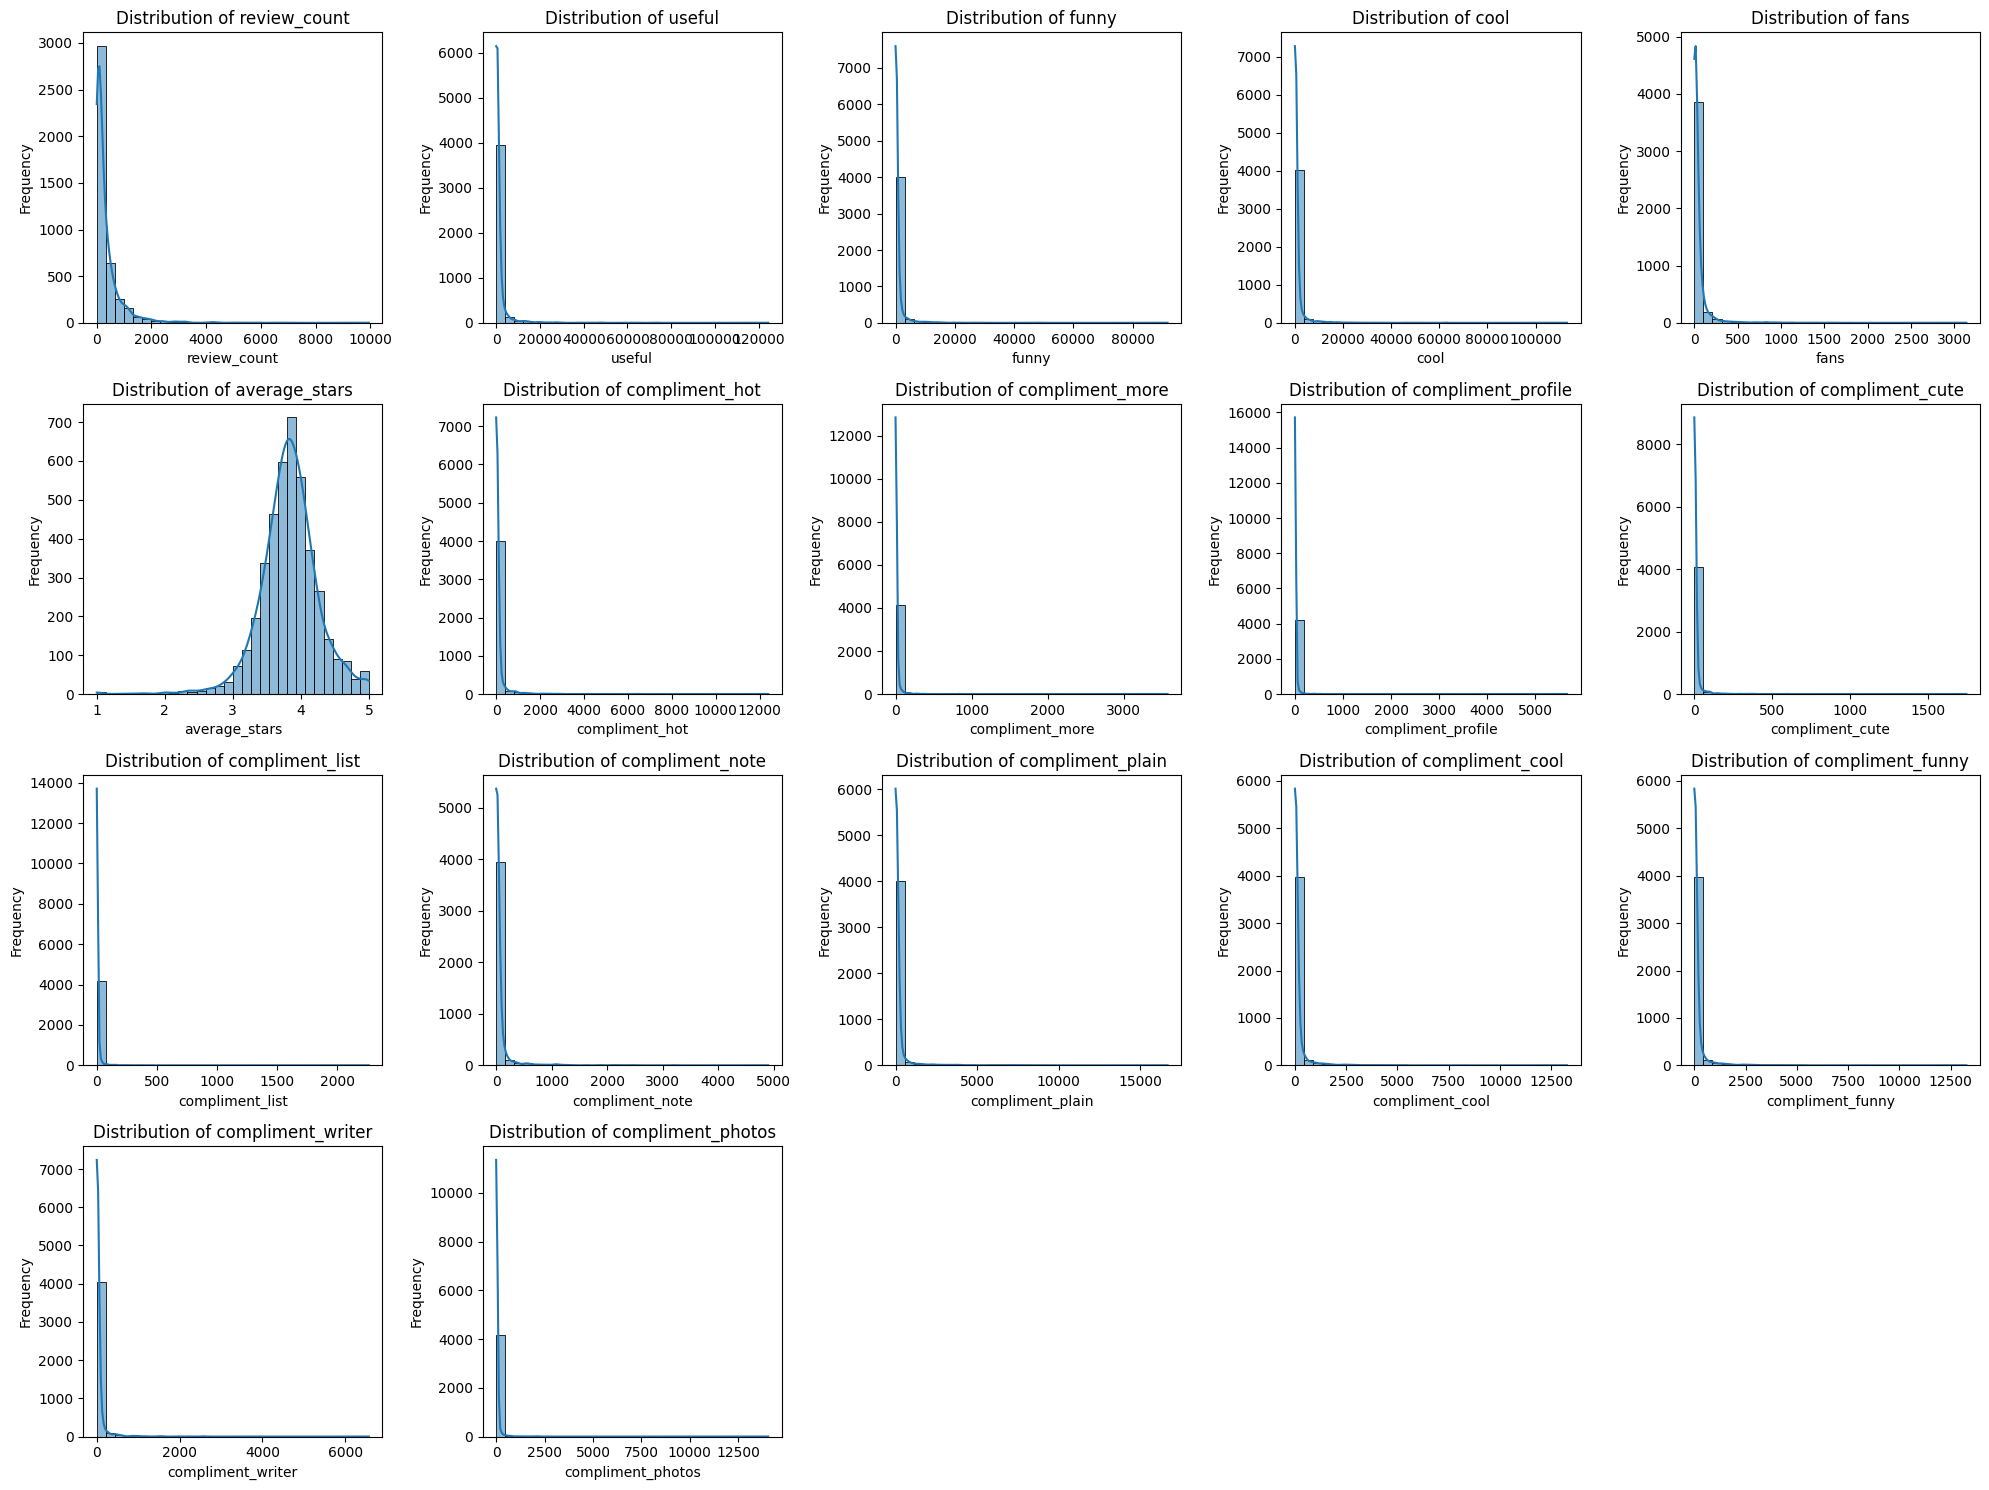